In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
sb.set()
import pandas as pd
import unidecode, unidecode
import datetime
%matplotlib inline

In [2]:
font = {'family' : 'normal',
#         'weight' : 'bold',
        'size'   : 28}

plt.rc('font', **font)

In [3]:
REPLACE_WITH = "sin informacion"

## 1.1 Utils

In [4]:
#Variables categoricas
def ver_atributo_categorico(df, col, limit=False, lim=10, hue=None, palette=None, log=False, f=None):
    l = df[col].unique().tolist()
    l_len = len(l)
    
    if log:
        print(df[col].nunique(), l)
    
    sb.set_color_codes("muted")
    
    if f==None: 
        f = plt.figure(figsize=(4,3))
    
    if limit:
        return sb.countplot(y=col, data=df, color="r", order=df[col].value_counts().index[:lim],hue=hue,palette=palette);
    else:
        return sb.countplot(y=col, data=df, color="r", order=df[col].value_counts().index[:l_len],hue=hue,palette=palette);

# Para usar en pattern_clean y contar valores mal formados en atributos categoricos
to_replace = ['Sin Información','a', '.', 'c', 'No indicado', 'No indica', 'n',
             'jdpqdp', 'no indicado', '*', 'fff', 'xxxx', 'eee', 
              'x', 'm', 'nn', 'rrr', 'wwwww', 'www', 0, 'k',]

def nulos_n_unicos(columna):
    print('Nulos', cot_mod[cot_mod[columna].isnull()].shape[0])
    print('No nulos', cot_mod[~cot_mod[columna].isnull()].shape[0])
    print('Unicos', cot_mod[columna].nunique())
    
    
def easy_clean(columna):
    print('Nulos', cot_mod[cot_mod[columna].isnull()].shape[0])
    cot_mod[columna].fillna(REPLACE_WITH, inplace=True)
    print('Easy Cleaned: ',cot_mod[cot_mod[columna].isnull()].shape)
    print('No nulos', cot_mod[~cot_mod[columna].isnull()].shape[0])
    
to_replace_space = ['\xa0']

def malformed_values(col):
    i=0
    for value in cot_all[col].tolist():
        if value in to_replace:
            i+=1
    print('Malformed values: ',i)

def pattern_clean(columna):
    cot_mod[columna].replace(
        to_replace,
        REPLACE_WITH, inplace=True, regex=False
    )

    cot_mod[columna].replace(
        to_replace_space,
        '', inplace=True, regex=True
    )
    
def view_malformations(columna, str_len):
    mask = (cot_mod[columna].str.len() < str_len)
    print(cot_mod[mask][columna].shape[0])
    print(cot_mod[mask][columna].tolist())

# 1 Select Data

In [4]:
cot_all = pd.read_excel("..\\..\\Datos\\working\\cotizaciones_all.xlsx")
cot_mod = pd.read_excel("..\\..\\Datos\\working\\cotizaciones_all.xlsx")
neg_all = pd.read_excel("..\\..\\Datos\\working\\negocios_all.xlsx")
neg_mod = pd.read_excel("..\\..\\Datos\\working\\negocios_all.xlsx")

In [6]:
cot_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16592 entries, 0 to 2916
Data columns (total 41 columns):
ID                     16592 non-null int64
Fecha Cotizacion       16592 non-null datetime64[ns]
Medio                  16592 non-null object
Tipo de Medio          16060 non-null object
Proyecto               16592 non-null object
Etapa                  16592 non-null object
Productos              16509 non-null object
Presencial             14565 non-null object
Remoto                 13282 non-null object
Jefe Comercial         16592 non-null object
Ejecutivo Comercial    16592 non-null object
Total Productos        16562 non-null float64
Descuentos             16548 non-null float64
Valor Final Venta      16548 non-null float64
RUT                    16592 non-null object
Nombre                 16592 non-null object
Apellido 1             16553 non-null object
Apellido 2             16185 non-null object
Nombre Completo        16592 non-null object
Telefono               1994

In [17]:
#Columnas sin Nulos
null_columns = cot_mod.columns[~cot_mod.isnull().any()]
cot_mod[null_columns].isnull().sum().index

Index(['ID', 'Fecha Cotizacion', 'Medio', 'Proyecto', 'Etapa',
       'Jefe Comercial', 'Ejecutivo Comercial', 'RUT', 'Nombre',
       'Nombre Completo', 'Region', 'Provincia', 'Comuna'],
      dtype='object')

In [18]:
#Columnas sin Nulos
null_columns = cot_mod.columns[cot_mod.isnull().any()]
print(cot_mod[null_columns].isnull().sum().index)
cot_mod[null_columns].isnull().sum().sort_values()

Index(['Tipo de Medio', 'Productos', 'Presencial', 'Remoto', 'Total Productos',
       'Descuentos', 'Valor Final Venta', 'Apellido 1', 'Apellido 2',
       'Telefono', 'Celular', 'Direccion', 'Correo Electronico', 'Sexo',
       'Estado Civil', 'Rango Edad', 'Fecha Nacimiento', 'Tipo Cliente',
       'Nacionalidad', 'N° Grupo Familiar', 'Actividad', 'Cargo',
       'Situacion Laboral', 'Empleador', 'Antiguedad Laboral', 'Profesión'],
      dtype='object')


Tipo Cliente              1
Correo Electronico        5
Total Productos          30
Celular                  38
Apellido 1               39
Descuentos               44
Valor Final Venta        44
Productos                83
Antiguedad Laboral      172
Apellido 2              407
Tipo de Medio           532
Sexo                   1869
Rango Edad             1980
Presencial             2027
Estado Civil           2049
Actividad              2350
Remoto                 3310
N° Grupo Familiar      5964
Profesión              9226
Direccion             11384
Nacionalidad          11744
Fecha Nacimiento      12701
Situacion Laboral     12795
Empleador             13588
Cargo                 13771
Telefono              14598
dtype: int64

In [15]:
cot_mod.drop(['Giro', 'Razon Social'], axis=1, inplace=True)

In [19]:
cot_mod.Remoto.unique()

array(['No', 'Si', nan], dtype=object)

In [26]:
# Macro Prepros

for column in cot_mod.columns:
    if cot_mod[column].dtype == object:
        cot_mod[column] = cot_mod[column].str.lower()
        
cot_mod = cot_mod.replace({
    'á':'a', 
    'é':'e', 
    'í':'i', 
    'ó':'o', 
    'ú':'u', 
    'ñ':'n'}, regex=True)

In [29]:
cot_mod.Sexo.unique()

array(['femenino', 'masculino', nan, 'sin informacion'], dtype=object)

# 1 Negocio y Venta

In [6]:
# bla = neg_all.groupby('ID Cotizacion').count()
# bla[bla['ID'] > 1]

In [7]:
# Venta Sesgadores
personas_ventas = dict()
total_ventas = 0
search = ['Escriturado', 'Entregado']

for group, frame in neg_all.groupby('RUT'):
    for id_cot in frame['Estado'].values:
        if search[0] == id_cot or search[1] == id_cot:
            total_ventas += 1
            if group not in personas_ventas.keys():
                personas_ventas[group] = 1
            else:
                personas_ventas[group] += 1
#             print(group, id_cot)

print('filas negocios', neg_all.shape[0])
print('filas ventas', total_ventas)
print('personas que hicieron negocio', neg_all.RUT.nunique())
print('personas que compraron',len(personas_ventas))

filas negocios 2347
filas ventas 291
personas que hicieron negocio 1103
personas que compraron 288


In [8]:
# ruts de los clientes en negocio
neg_ids = neg_all['ID Cotizacion'].unique().tolist()
# print(neg_ids)
# venta_ids = neg_all[neg_all['ID Cotizacion'].isin(personas_ventas)]

# print(len(venta_ids))

In [9]:
cot_mod['Negocio'] = cot_mod['ID'].isin(neg_ids)
print(cot_mod[cot_mod['Negocio'] == True].shape[0])

cot_mod['Venta'] = cot_mod['ID'].isin(personas_ventas)
print(cot_mod[cot_mod.Venta == True].shape[0])

2336
0


In [10]:
# negocio_true = cot_mod[cot_mod['Negocio'] == True]['ID'].tolist()
# negocio_notin_cotizacion = [x if x in negocio_true else x for x in neg_ids]
# negocio_notin_cotizacion
c = cot_mod[cot_mod.Negocio == True]['ID'].tolist()

for i in neg_ids:
    if i not in c:
        print(i)

134848
60373
79802
136425


In [11]:
cot_mod.reset_index(inplace=True)
cot_mod.head()

,index,ID,Fecha Cotizacion,Medio,Tipo de Medio,Proyecto,Etapa,Productos,Presencial,Remoto,...,Nacionalidad,N° Grupo Familiar,Actividad,Cargo,Situacion Laboral,Empleador,Antiguedad Laboral,Profesión,Negocio,Venta
0,0,111502,2017-07-27 15:46:54,RECORRIDO POR EL SECTOR,Paseo,Altos del Valle,ADV - Etapa 1,"TB-104,Est-65",Si,No,...,NaN,3,Tecnico,NaN,NaN,NaN,0.0,NaN,True,False
1,1,111611,2017-07-29 13:37:05,RECONTACTO,Recontacto,Altos del Valle,ADV - Etapa 1,"TA-302,Est-41,Bod-02",No,No,...,NaN,Sin Información,Empleado,NaN,NaN,NaN,0.0,NaN,True,False
2,2,111629,2017-07-29 16:41:15,RECORRIDO POR EL SECTOR,Paseo,Altos del Valle,ADV - Etapa 1,"TA-303,Est-01",Si,No,...,NaN,3,Empleado,NaN,NaN,NaN,0.0,NaN,False,False
3,3,111766,2017-07-31 11:01:57,RECONTACTO,Recontacto,Altos del Valle,ADV - Etapa 1,"TA-302,Est-41,Bod-06",No,No,...,Chilena,Sin Información,Empleado,a,Sin Información,a,1.0,Empresario,True,False
4,4,111794,2017-07-31 15:52:32,RECORRIDO POR EL SECTOR,Paseo,Altos del Valle,ADV - Etapa 1,"TA-604,Est-01",Si,No,...,Chilena,4,Profesional,NaN,NaN,NaN,0.0,Constructor Civil,False,False


# 2 Clean Data

In [12]:
# variables a impiar y chequear

# Limpiar variable fecha de nacimiento de alguna manera
# Limpiar variable Sexo usando rutificador
# Limpar variables Direccion usando en lo posible el rutificador y otras fuentes
# Llenar mv en decuentos con 0

## 2.1 Rut
Arreglar Ruts, luego validarlos para aplicar data crawling en rutificador.
Si el rut esta mal escrito por ende no es valido, se prosigue a buscar el rut por el nombre y arreglar el rut.
Todo esto con el find de obtener el genero, direccion, latiyud y longitud del cotizante

### 2.1.1 Funciones
Funciones para tratar los ruts

In [13]:
# #Eliminar indice 1704 y arreglar rut max boris
# print('Ruts que no hicieron negocios y no son validos')
# p_noneg_invalidrut = cot_mod[(cot_mod['Valid Rut'] == False) & (cot_mod['Negocio'] == False)][['Nombre','RUT','Negocio','Valid Rut','Clean Rut']]
# len(p_noneg_invalidrut)

In [14]:
import chile_rut
import re

def format_rut(x):
    rut = x.split('-')
    l_s = list(rut[0])
    r_l = l_s[::-1]
    new = []
    i = 0
    new.append(rut[1])
    new.append('-')
    for c in r_l:
        if i==3:
            new.append('.')
            i = 0
        new.append(c)
        i +=1
    rut = ''.join(new[::-1])
    return rut

def val_rut(x):
    x = str(x)
    if len(x) == 0:
        return False
    x = re.sub('[.|!@#$]', '', x)
    
    if len(x.split('-')) >= 2:
        return chile_rut.validate_rut(x)
    else:
        x = x[:-1] + '-' + x[-1]
        return chile_rut.validate_rut(x)

def clean_rut(x):
    x = str(x)
    if len(x) == 0:
        return False
    x = re.sub('[.|!@#$]', '', x)
    
    if len(x.split('-')) >= 2:
        return x
    else:
        x = x[:-1] + '-' + x[-1]
        return x

cot_mod['Clon Rut'] = cot_mod['RUT'][0:]
cot_mod['Clean Rut'] = [clean_rut(x) for x in cot_mod['Clon Rut'].values]
cot_mod['Valid Rut'] = [val_rut(x) for x in cot_mod['Clean Rut'].values]

neg_mod['Clon Rut'] = neg_mod['RUT'][0:]
neg_mod['Clean Rut'] = [clean_rut(x) for x in neg_mod['Clon Rut'].values]
neg_mod['Valid Rut'] = [val_rut(x) for x in neg_mod['Clean Rut'].values]


In [15]:
cot_mod['Clon Rut']

0        14273551-2
1        13309954-9
2        14583354-k
3         7188659-k
4        13377606-0
5        16863328-9
6        17046821-k
7        17046821-k
8        13951239-1
9        12920930-5
10       12920930-5
11       10076241-2
12       15625979-9
13        9879501-4
14       17346494-0
15       10065290-0
16       16763770-1
17       13842771-4
18        6521908-5
19       16282675-1
20       16240108-4
21       12524132-8
22       16863328-9
23       19270890-7
24       15912017-1
25       12523213-2
26       12523213-2
27       15912197-6
28       17041530-2
29        8399766-4
            ...    
16562    17758410-k
16563    14423710-2
16564    16896206-1
16565    15186475-9
16566    16763798-1
16567    10028666-1
16568    10028666-1
16569    10028666-1
16570    17853463-7
16571    10619053-4
16572    10619053-4
16573    17045141-4
16574    14391486-0
16575    15173211-9
16576     9289690-0
16577    12732636-3
16578    12732636-3
16579    12732636-3
16580    18419794-4


In [16]:
valores_mal_formados = dict()
valores_mal_formados['neg'] = dict()
valores_mal_formados['cot'] = dict()

### 2.1.1 Insights
Revision de los ruts, mal formaciones, ruts malos que tienen negocios, etc

In [17]:
mask = neg_mod['Valid Rut'] == False
rut_neg_novalid = neg_mod[mask]
print(rut_neg_novalid['ID'].count())
valores_mal_formados['neg']['rut'] = rut_neg_novalid['ID'].count() 

mask = cot_mod['Valid Rut'] == False
rut_cot_novalid = cot_mod[mask]
print(rut_cot_novalid['ID'].count())
valores_mal_formados['cot']['rut'] = rut_cot_novalid['ID'].count()

3
69


In [18]:
cot_mod.at[10507, 'Clon Rut'] = '14.030.274-0'
cot_mod.at[10621, 'Clon Rut'] = '14.030.274-0'
cot_mod.drop([15379], axis=0, inplace=True)

cot_mod.at[425,'Clon Rut'] = '10.117.605-3'
cot_mod.at[827,'Clon Rut'] = '4.379.605-4'
cot_mod.at[828,'Clon Rut'] = '4.379.605-4'
cot_mod.at[870,'Clon Rut'] = '12.844.757-1'
cot_mod.at[871,'Clon Rut'] = '12.844.757-1'
cot_mod.at[872,'Clon Rut'] = '12.844.757-1'
cot_mod.at[890,'Clon Rut'] = '10.658.228-9'
cot_mod.at[891,'Clon Rut'] = '10.658.228-9'
cot_mod.at[892,'Clon Rut'] = '10.658.228-9'
cot_mod.at[1017,'Clon Rut'] = '15.777.609-6'
cot_mod.at[1038,'Clon Rut'] = '12.844.757-1'
cot_mod.at[1039,'Clon Rut'] = '12.844.757-1'
cot_mod.at[1157,'Clon Rut'] = '15.961.611-8'
cot_mod.at[1158,'Clon Rut'] = '15.961.611-8'
cot_mod.at[1159,'Clon Rut'] = '15.961.611-8'
cot_mod.at[2537,'Clon Rut'] = '17.321.915-6'
cot_mod.at[3150,'Clon Rut'] = '13.941.422-5'
cot_mod.at[5853,'Clon Rut'] = '12.207.750-0'
cot_mod.at[5855,'Clon Rut'] = '13.508.090-K'
cot_mod.at[5865,'Clon Rut'] = '12.207.750-0'
cot_mod.at[9066,'Clon Rut'] = '13.941.422-5'
cot_mod.at[9067,'Clon Rut'] = '13.941.422-5'
cot_mod.at[9068,'Clon Rut'] = '13.941.422-5'
cot_mod.at[10817,'Clon Rut'] = '14.354.185-1'
cot_mod.at[11802,'Clon Rut'] = '13.994.909-9'
cot_mod.at[11835,'Clon Rut'] = '16.620.489-5'
cot_mod.at[11838,'Clon Rut'] = '8.272.869-4'
cot_mod.at[11839,'Clon Rut'] = '8.272.869-4'
cot_mod.at[11840,'Clon Rut'] = '8.272.869-4'
cot_mod.at[12060,'Clon Rut'] = '6.180.535-4'
cot_mod.at[12154,'Clon Rut'] = '8.639.046-9'
cot_mod.at[12181,'Clon Rut'] = '13.413.569-7'
cot_mod.at[12216,'Clon Rut'] = '9.559.524-3'
cot_mod.at[12691,'Clon Rut'] = '17.321.289-5'
cot_mod.at[12819,'Clon Rut'] = '8.495.983-9'
cot_mod.at[13150,'Clon Rut'] = '16.036.374-6'
cot_mod.at[14026,'Clon Rut'] = '15.780.460-K'
cot_mod.at[14027,'Clon Rut'] = '15.780.460-K'
cot_mod.at[15255,'Clon Rut'] = '17.896.434-8'
cot_mod.at[15256,'Clon Rut'] = '17.896.434-8'
cot_mod.at[15412,'Clon Rut'] = '13.133.359-5'
cot_mod.at[15414,'Clon Rut'] = '14.359.960-4'
cot_mod.at[15563,'Clon Rut'] = '15.854.369-9'
cot_mod.at[15564,'Clon Rut'] = '15.854.369-9'
cot_mod.at[15646,'Clon Rut'] = '15.999.180-6'
cot_mod.at[15647,'Clon Rut'] = '15.999.180-6'
cot_mod.at[15671,'Clon Rut'] = '17.206.422-1'
cot_mod.at[15782,'Clon Rut'] = '14.060.162-4'
cot_mod.at[15881,'Clon Rut'] = '17.540.251-9'


In [19]:
cot_mod['Clean Rut'] = [clean_rut(x) for x in cot_mod['Clon Rut'].values]
cot_mod['Valid Rut'] = [val_rut(x) for x in cot_mod['Clean Rut'].values]

In [20]:
print('Ruts en Cotizacion que hicieron negocios pero no son validos')
p_neg_novalid_noclean = cot_mod[(cot_mod['Valid Rut'] == False)][['Negocio','Sexo','Nombre Completo','RUT','Comuna','Valid Rut', 'Direccion']]
print(p_neg_novalid_noclean.shape[0])
p_neg_novalid_noclean.reset_index().head(100)

Ruts en Cotizacion que hicieron negocios pero no son validos
17


,index,Negocio,Sexo,Nombre Completo,RUT,Comuna,Valid Rut,Direccion
0,1046,False,Femenino,Marujita Capilla Jaña,5663292-k,Concepción,False,NaN
1,1147,False,NaN,Patricia Sanhueza Fernandez,15753102-7,Concepción,False,NaN
2,1148,False,NaN,Patricia Sanhueza Fernandez,15753102-7,Concepción,False,NaN
3,1149,False,NaN,Patricia Sanhueza Fernandez,15753102-7,Concepción,False,NaN
4,1150,False,NaN,Patricia Sanhueza Fernandez,15753102-7,Concepción,False,NaN
5,1166,False,NaN,Teresa Muñoz .,17346561-1,Concepción,False,NaN
6,1625,False,Masculino,Oscar Gutierrez *,19457385-6,Santiago,False,NaN
7,1626,False,Masculino,Oscar Gutierrez *,19457385-6,Santiago,False,NaN
8,1851,False,Masculino,Cristian Garda .,7879943-1,Concepción,False,NaN
9,2147,False,Masculino,Giovanni Flores .,16.546.158-2,Concepción,False,NaN


In [21]:
print('Ruts en Negocio que no son validos')
p_neg_novalid_noclean = neg_mod[(neg_mod['Valid Rut'] == False)][['Sexo','Nombre Completo','RUT','Comuna','Valid Rut', 'Direccion']]
print(p_neg_novalid_noclean.shape[0])
p_neg_novalid_noclean.reset_index().head(25)

Ruts en Negocio que no son validos
3


,index,Sexo,Nombre Completo,RUT,Comuna,Valid Rut,Direccion
0,1220,Masculino,max boris chandia gonzalez,14030274-6,Hualpén,False,pje cartagena 827
1,1266,Masculino,max boris chandia gonzalez,14030274-6,Hualpén,False,pje cartagena 827
2,143,Masculino,Error Cliente,15516786-8,Concepción,False,SERRANO 177 Depto 501


In [22]:
cot_mod['Clean Rut'] = [clean_rut(x) for x in cot_mod['RUT'].values]
cot_mod['Valid Rut'] = [val_rut(x) for x in cot_mod['RUT'].values]
cot_mod['New Valid Rut'] = [val_rut(x) for x in cot_mod['Clean Rut'].values]
cot_mod['Format Rut'] = [format_rut(x) for x in cot_mod['Clean Rut'].values]

In [23]:
cot_mod['Format Rut']

0        14.273.551-2
1        13.309.954-9
2        14.583.354-k
3         7.188.659-k
4        13.377.606-0
5        16.863.328-9
6        17.046.821-k
7        17.046.821-k
8        13.951.239-1
9        12.920.930-5
10       12.920.930-5
11       10.076.241-2
12       15.625.979-9
13        9.879.501-4
14       17.346.494-0
15       10.065.290-0
16       16.763.770-1
17       13.842.771-4
18        6.521.908-5
19       16.282.675-1
20       16.240.108-4
21       12.524.132-8
22       16.863.328-9
23       19.270.890-7
24       15.912.017-1
25       12.523.213-2
26       12.523.213-2
27       15.912.197-6
28       17.041.530-2
29        8.399.766-4
             ...     
16562    17.758.410-k
16563    14.423.710-2
16564    16.896.206-1
16565    15.186.475-9
16566    16.763.798-1
16567    10.028.666-1
16568    10.028.666-1
16569    10.028.666-1
16570    17.853.463-7
16571    10.619.053-4
16572    10.619.053-4
16573    17.045.141-4
16574    14.391.486-0
16575    15.173.211-9
16576     

In [24]:
valid_ruts = cot_mod[cot_mod['Valid Rut']== True]['Clean Rut']
valid_ruts.to_csv("..\\..\\ruts_validos_scrap.csv")

In [25]:
mask = neg_mod['Valid Rut'] == False
rut_neg_novalid = neg_mod[mask]
print(rut_neg_novalid['ID'].count())

mask = cot_mod['Valid Rut'] == False
rut_cot_novalid = cot_mod[mask]
print(rut_cot_novalid['ID'].count())

3
68


### 2.1.1 Ruts Scrapped

In [26]:
#Ruts y sus datos obtenidos de forma valida
ruts_scrapped = pd.read_csv('..\\..\\DataCrawling\\rut\\ruts_validos_bkp.csv')
ruts_scrapped['RUT'] = [x.replace(' ','') for x in ruts_scrapped['RUT'].values]
ruts_scrapped['RUT'] = [x.replace('K','k') for x in ruts_scrapped['RUT'].values]
print(ruts_scrapped.shape)
print(ruts_scrapped.head(2))

(6012, 5)
                                  Name           RUT Gender  \
0   SCHNEIDER BARRERA RICARDO ERNESTO   10.023.348-7   VAR    
1     MORALES ESPINOZA CLAUDIO ANDRES   10.020.262-k   VAR    

                             Adress               Comuna  
0                J  CISTERNAS 1612            LA SERENA   
1   ALEJANDRO SEXTO 2787LZO ARENAS    CONCEPCION CENTRO   


### 2.1.1 Ruts Scrapped merge a DF principal

In [27]:
# # merge
# cot_mod_cp = cot_mod.copy()
# cot_mod_cp['Format Rut'] = [x.replace('K','k') for x in cot_mod_cp['Format Rut'].values]
# cot_merge = pd.merge(cot_mod_cp, ruts_scrapped,how='left', left_on='Format Rut', right_on='RUT')
# # print(cot_merge.columns)
# columns = ['Format Rut','Valid Rut','Negocio','Nombre','Apellido 1','Name','Gender','Sexo',
#            'Adress','Direccion', 'Region','Provincia', 'Comuna_x', 'Comuna_y']
# cot_merge[columns][cot_merge['Sexo'].isnull()].shape

In [28]:

# ruts_scrapped['RUT'] = [x.replace(' ','') for x in ruts_scrapped['RUT'].values]

# # df = pd.merge(cot_mod_cp,ruts_scrapped,how='outer',left_on='Format Rut',right_on='RUT')
# df = pd.merge(cot_mod_cp,ruts_scrapped,how='outer',left_on='Format Rut',right_on='RUT')

# ruts_scrapped.to_csv('..\\..\\Datos\\working\\ruts_scrapped_mod.csv')
# df.to_excel('..\\..\\Datos\\tmp.xlsx')

## 2.2 Profesion

In [29]:
col = 'Profesión'

In [30]:
nulos_n_unicos(col)

Nulos 9226
No nulos 7365
Unicos 129


In [31]:
malformed_values(col)

Malformed values:  0


In [32]:
view_malformations(col, 4)

0
[]


129 [nan, 'Empresario', 'Constructor Civil', 'Traductor e Interprete', 'Matrona', 'Odontólogo', 'Profesor', 'Ingeniería en Biotecnología', 'Otro', 'Ingeniero Eléctrico', 'Técnico en Construcción', 'Fonoaudiólogo', 'Diseño Industrial', 'Mecánico Industrial', 'Empleado Público', 'Enfermería', 'Ingeniero en Administración', 'Contador Auditor', 'Ingeniero Comercial', 'Ingeniero en Construcción', 'Ingeniero', 'Empleado', 'Agronomo', 'Prevencionista de Riesgos', 'Ingeniero Civil Química', 'Administrador', 'Ingeniero Civil Industrial', 'Nutrición y Dietética', 'Tecnólogo Médico', 'Abogado', 'Médico', 'Educadora de Párvulos', 'Administrador Público', 'Periodista', 'Ingeniero de Ejecución', 'Psicólogo', 'Arquitecto', 'Ingeniero Civil Electrónico', 'Ingeniero en Prevención de Riesgo', 'Ingeniero Civil Eléctrico', 'Vendedor', 'Pastor', 'Administración de Empresas', 'Administrativo', 'Docente', 'Ingeniero Agronomo', 'Trabajo Social', 'Ingeniero Biomédica', 'Dueña De Casa', 'Ingeniero Civil en Info

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


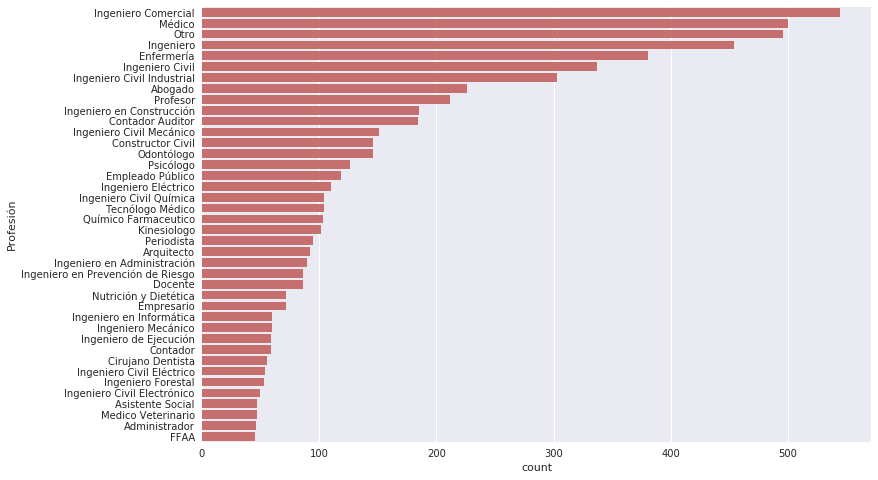

In [33]:
ver_atributo_categorico(cot_all, col, log=True, limit = True, lim=40)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


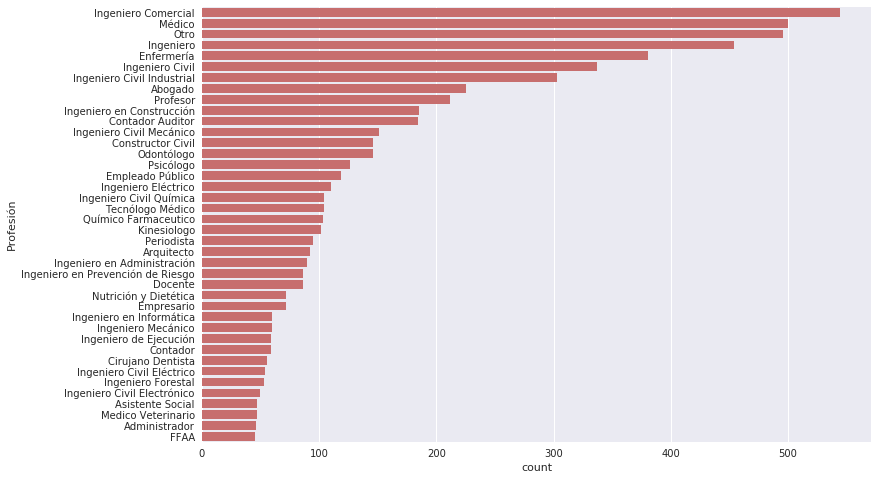

In [34]:
ver_atributo_categorico(cot_mod,'Profesión', limit = True, lim=40)

In [35]:
easy_clean(col)
pattern_clean(col)


Nulos 9226
Easy Cleaned:  (0, 49)
No nulos 16591


Nulos 0
No nulos 16591
Unicos 130


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


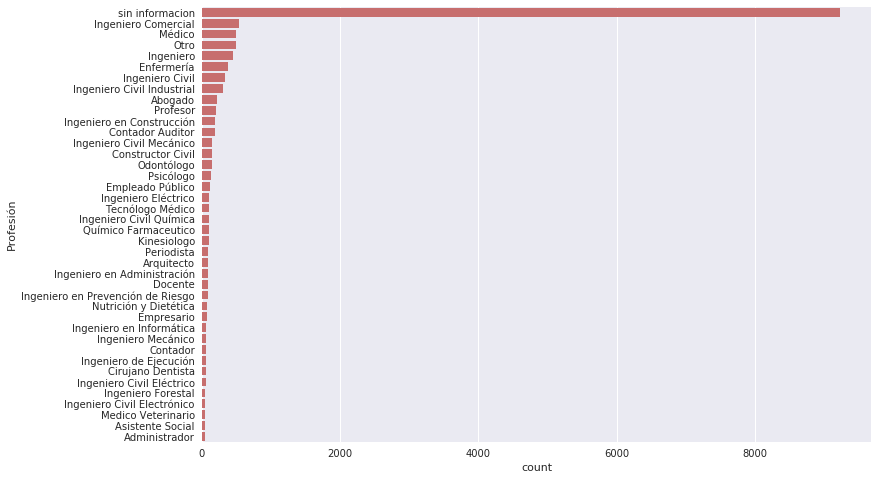

In [36]:
nulos_n_unicos(col)
ver_atributo_categorico(cot_mod, col, limit = True, lim=40)

# Derviando Area Profesión

## 2.2 Estado Civil

In [37]:
col = 'Estado Civil'

In [38]:
nulos_n_unicos(col)

Nulos 2049
No nulos 14542
Unicos 9


In [39]:
malformed_values(col) # Sin información

Malformed values:  5065


In [40]:
view_malformations(col, 5)

0
[]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


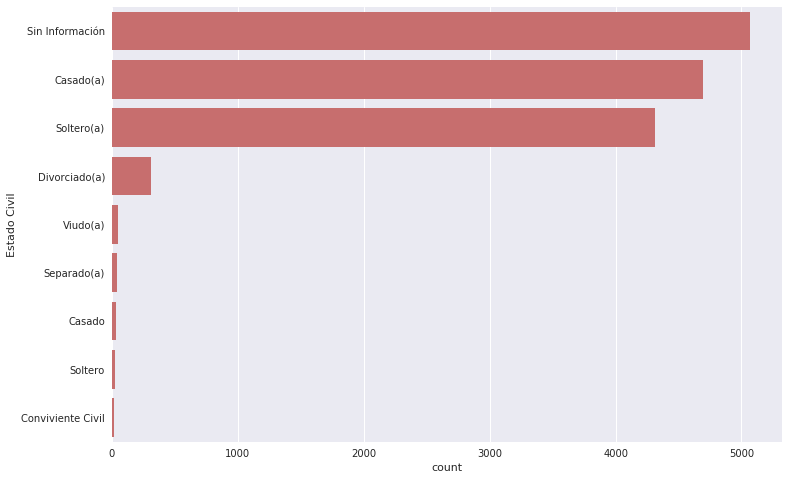

In [41]:
ver_atributo_categorico(cot_mod,col)

In [42]:
easy_clean(col)

pattern_clean(col)

Nulos 2049
Easy Cleaned:  (0, 49)
No nulos 16591


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


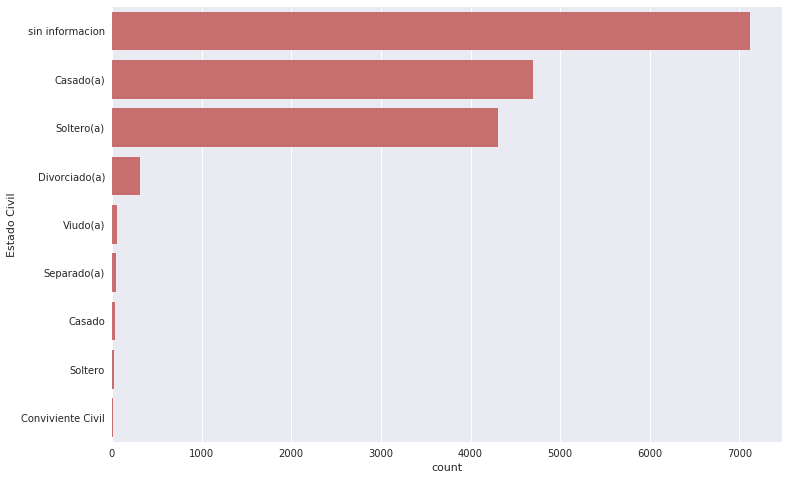

In [43]:
ver_atributo_categorico(cot_mod,'Estado Civil')

## 2.2 Actividad

Nulos 2350
No nulos 14241
Unicos 6
6 ['Tecnico', 'Empleado', 'Profesional', 'Independiente (no profesional)', nan, 'Dueña de casa', 'Estudiante']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


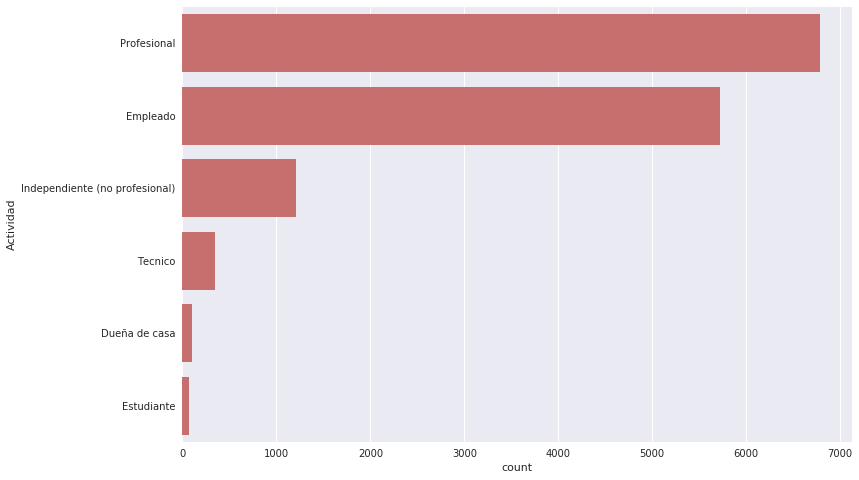

In [44]:
nulos_n_unicos('Actividad')
ver_atributo_categorico(cot_mod, 'Actividad', log=True, limit = True, lim=30)

In [45]:
easy_clean('Actividad')

Nulos 2350
Easy Cleaned:  (0, 49)
No nulos 16591


7 ['Tecnico', 'Empleado', 'Profesional', 'Independiente (no profesional)', 'sin informacion', 'Dueña de casa', 'Estudiante']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


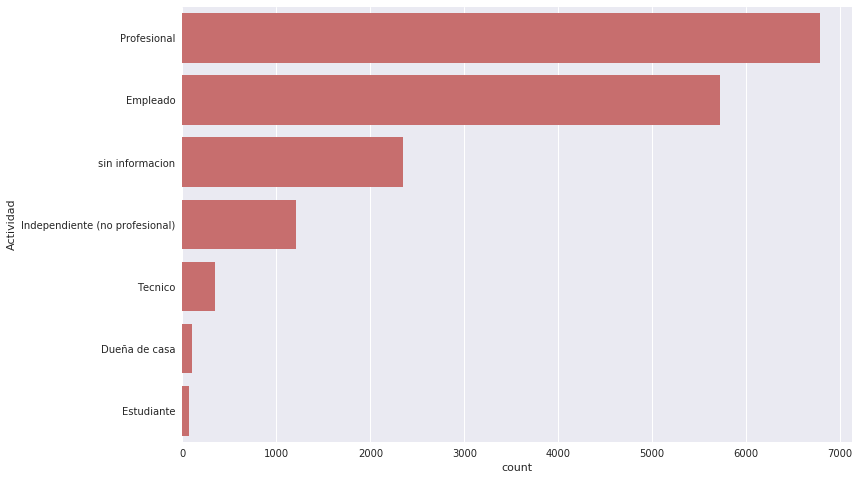

In [46]:
# print(cot_mod.Actividad.isnull().sum())
ver_atributo_categorico(cot_mod, 'Actividad', log=True, limit = True, lim=30)

## 2.2 Empleador

509 [nan, 'a', 'Norteamericano / USS / UDD', 'Cesfam Lautaro Caceres', 'BioForest S.A.', 'DGAC', 'ACCIONA agua', 'Constructora Aitue \xa0\xa0\xa0', 'Arrigoni Ing.Y Const. S.A', 'Soc. Transportes Maritimo Service Ltda', 'Traumatologico', 'Besalco MD Montajes', 'Management Solutions Limitada', 'Forestal Celco', 'Caufmann', 'Inmobiliaria Los Pellines S.A.', 'MOP', '*', 'DFV Ingeniería y Gestión', 'Clinical Service', 'Hospital de Tomé', 'Municipalidad de Penco', 'Sanatorio Aleman \xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0', 'Huachipato', 'Catim', 'CAP \xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0', 'Municipalidad de Lota', 'Banco Estado', 'SVTI', 'Forestal papelera concepción', 'H&M Hennes & Mauritz SPA', '.', 'Chilena Consolidada seguros generales', 'Sociedad Educacional Juan Bosco LTDA', 'DAEM Hualpen', 'Ausenco Chile LTDA', 'HOSPITAL CLINICO DEL SUR SPA', 'Corporación Adventista \xa0\xa0\xa0\xa0\xa0\xa0\xa0', '\xa0\xa0

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


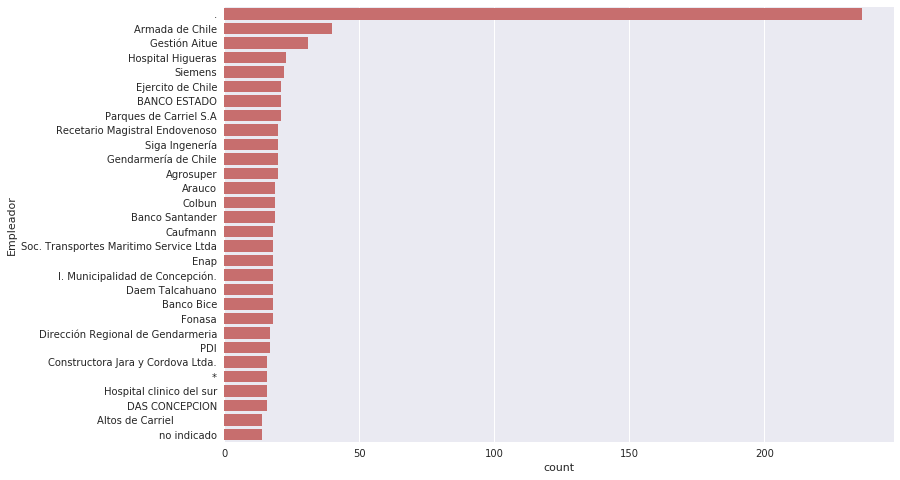

In [47]:
ver_atributo_categorico(cot_mod,'Empleador',log=True, limit = True, lim=30)

Nulos 13587
No nulos 3004
Unicos 509


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


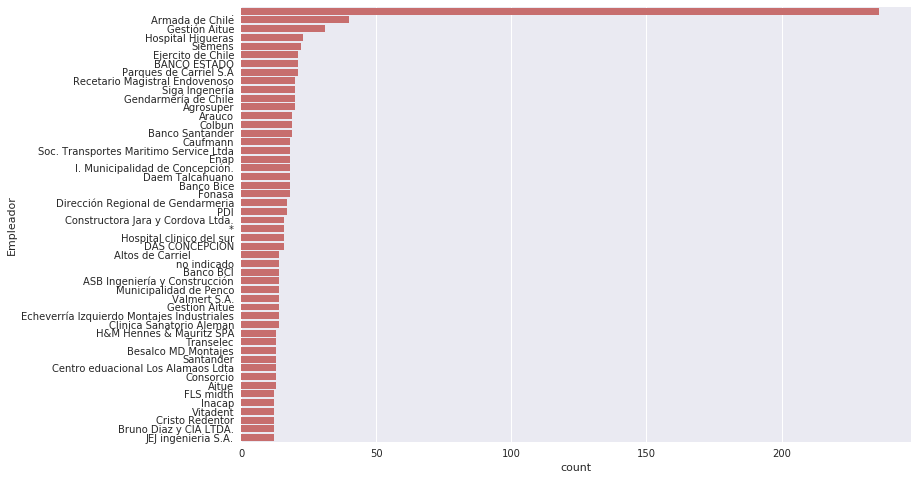

In [48]:
nulos_n_unicos('Empleador')
ver_atributo_categorico(cot_mod,'Empleador',log=False, limit = True, lim=50)

In [49]:
easy_clean('Empleador')
pattern_clean('Empleador')

Nulos 13587
Easy Cleaned:  (0, 49)
No nulos 16591


Nulos 0
No nulos 16591
Unicos 493


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


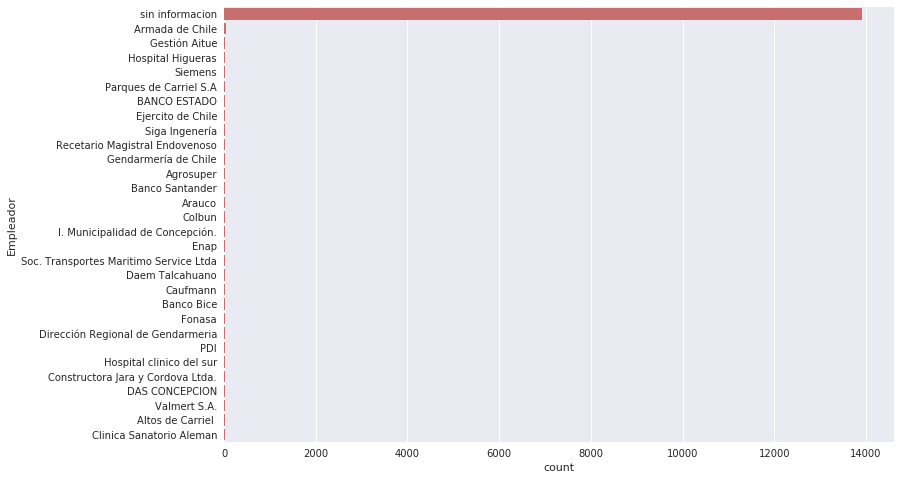

In [50]:
nulos_n_unicos('Empleador')
ver_atributo_categorico(cot_mod,'Empleador',log=False, limit = True, lim=30)

## 2.2 Cargo

443 [nan, 'a', 'Profesora', 'Matrona', 'Odontologo', 'Biotecnologo', 'Metereologo', 'Ingeniero de mantención', 'Administrador de Obras', 'Vendedor Técnico', 'Enfermeria', 'Consultor Senior 2', 'Jefe de costos y presupuestos', 'Jefe área de repuestos', 'Supervisor Inmobiliario.', 'Jubilada', 'Jejfa de local', 'Ingeniero Civil', 'Ingeniero', 'Inspección técnica', 'Médico', 'Directora', 'Jefe de area', 'Psicóloga', 'Analista de control de gestión', 'enfermera de gestion', 'Ejecutivo Plataforma Normalizacion', 'Super Intendente de Terminal', 'Enfermera', 'partner manager', 'Ingeniero.', 'Ejecutivo de Negocios', '.', 'Fonoaudiólogo', 'Control de proyecto', 'ENCARGADO DE COMUNICACIONES', '\xa0\xa0\xa0\xa0', 'Chef', 'Independiente', 'Jefe Planificación', 'gerente de tienda', 'enfermera', 'vendedora', 'administrativo', 'Profesional de Obras', 'Gestor de inversiones senior', 'jefe de desarrollo', 'Pediatra', 'Medico Cirujano', 'Dueño', 'docente', 'Ingeniario civil en obras civiles', 'TENIENTE P

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


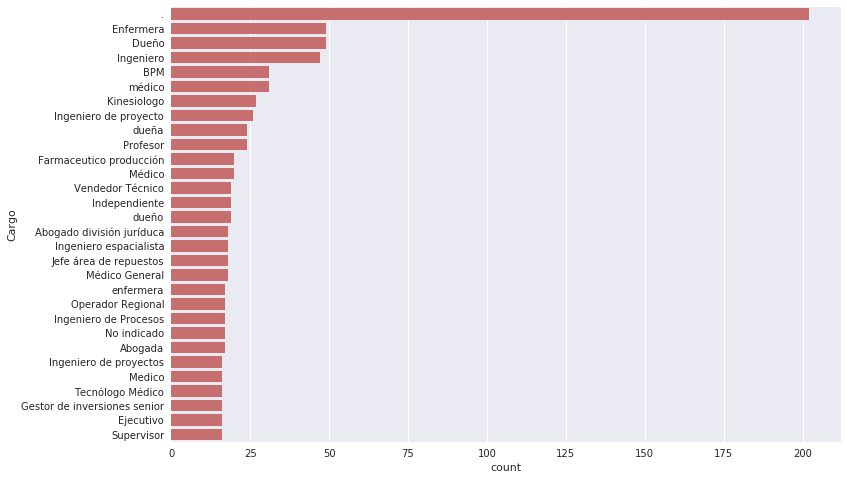

In [51]:
ver_atributo_categorico(cot_mod,'Cargo',log=True, limit = True, lim=30)

Nulos 13771
No nulos 2820
Unicos 443


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


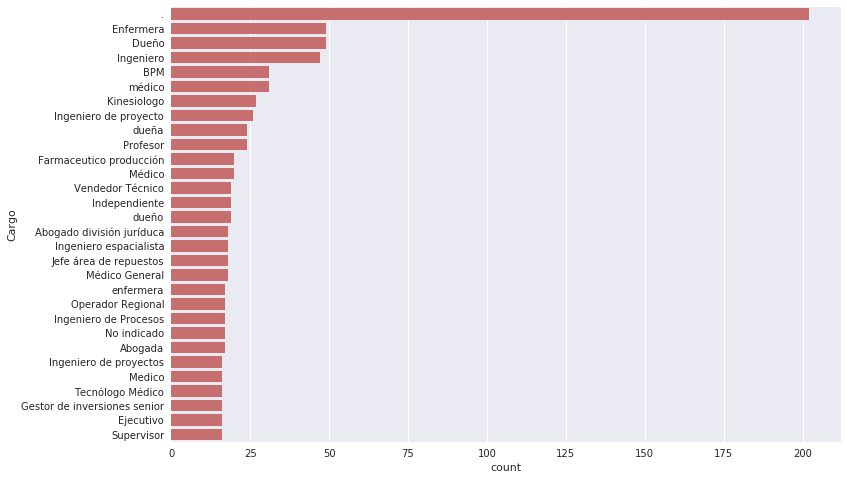

In [52]:
nulos_n_unicos('Cargo')
ver_atributo_categorico(cot_mod,'Cargo',log=False, limit = True, lim=30)

In [53]:
easy_clean('Cargo')

to_replace.extend(['a', '.', '\xa0\xa0\xa0\xa0', 'c', 'No indicado', 'No indica', 'n',
             'jdpqdp', 'no indicado', '*', 'fff', 'xxxx', 'eee'])

pattern_clean('Cargo')

Nulos 13771
Easy Cleaned:  (0, 49)
No nulos 16591


0
426


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


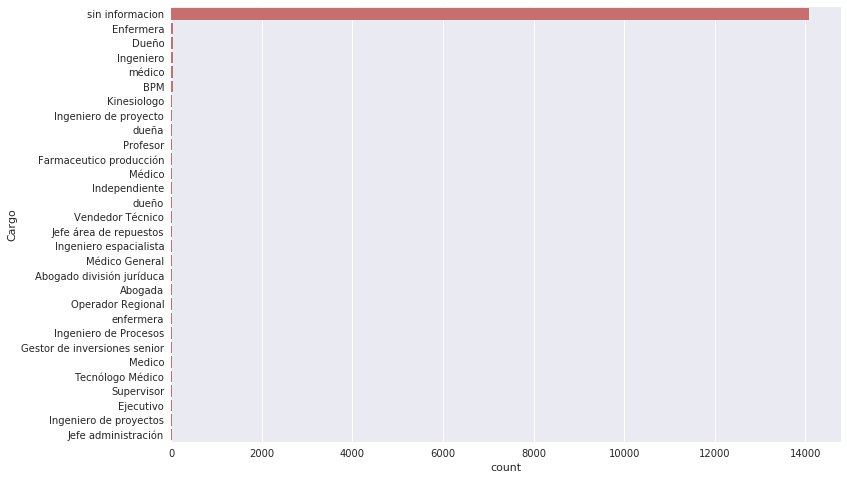

In [54]:
print(cot_mod.Cargo.isnull().sum())
print(cot_mod.Cargo.nunique())
ver_atributo_categorico(cot_mod,'Cargo',log=False, limit = True, lim=30)

## 2.2 Grupo Familiar

Nulos 5964
No nulos 10627
Unicos 9


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


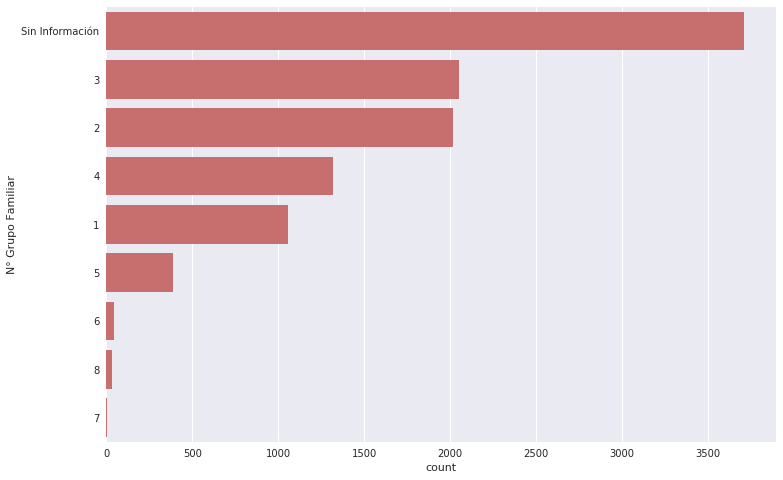

In [55]:
nulos_n_unicos('N° Grupo Familiar')
ver_atributo_categorico(cot_mod,'N° Grupo Familiar',log=False, limit = True, lim=30)

In [56]:
easy_clean('N° Grupo Familiar')

to_replace = ['\xa0']

cot_mod['N° Grupo Familiar'].replace(
    ['Sin Información'],
    REPLACE_WITH, inplace=True, regex=True
)

cot_mod['N° Grupo Familiar'].replace(
    to_replace_space,
    '', inplace=True, regex=True
)

Nulos 5964
Easy Cleaned:  (0, 49)
No nulos 16591


0
9


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


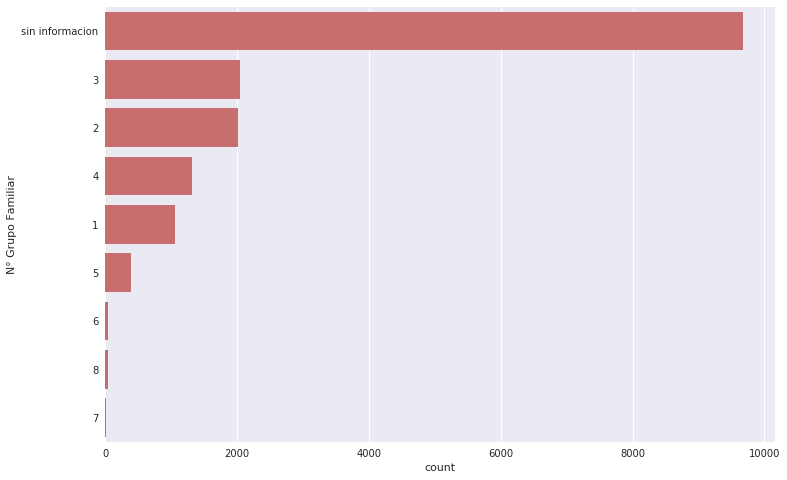

In [57]:
print(cot_mod['N° Grupo Familiar'].isnull().sum())
print(cot_mod['N° Grupo Familiar'].nunique())
ver_atributo_categorico(cot_mod,'N° Grupo Familiar',log=False, limit = True, lim=30)

## 2.2 Antiguedad Laboral

Nulos 172
No nulos 16419
Unicos 35
35 [0.0, 1.0, 5.0, 2.0, 29.0, 6.0, 3.0, 37.0, 7.0, 13.0, nan, 9.0, 11.0, 10.0, 15.0, 4.0, 20.0, 22.0, 12.0, 8.0, 40.0, 31.0, 18.0, 17.0, 32.0, 16.0, 27.0, 14.0, 24.0, 23.0, 33.0, 19.0, 28.0, 21.0, 30.0, 100.0]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


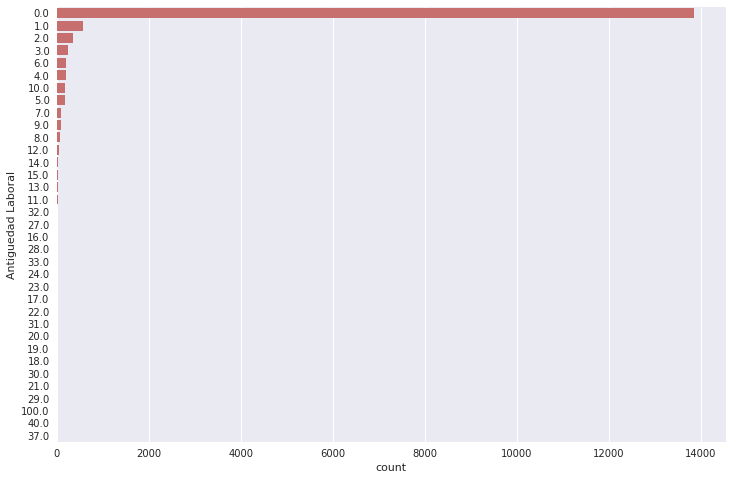

In [58]:
nulos_n_unicos('Antiguedad Laboral')
ver_atributo_categorico(cot_mod,'Antiguedad Laboral',log=True)

In [59]:
easy_clean('Antiguedad Laboral')

cot_mod['Antiguedad Laboral'].replace(
    to_replace_space,
    '', inplace=True, regex=True
)

Nulos 172
Easy Cleaned:  (0, 49)
No nulos 16591


36 [0.0, 1.0, 5.0, 2.0, 29.0, 6.0, 3.0, 37.0, 7.0, 13.0, 'sin informacion', 9.0, 11.0, 10.0, 15.0, 4.0, 20.0, 22.0, 12.0, 8.0, 40.0, 31.0, 18.0, 17.0, 32.0, 16.0, 27.0, 14.0, 24.0, 23.0, 33.0, 19.0, 28.0, 21.0, 30.0, 100.0]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


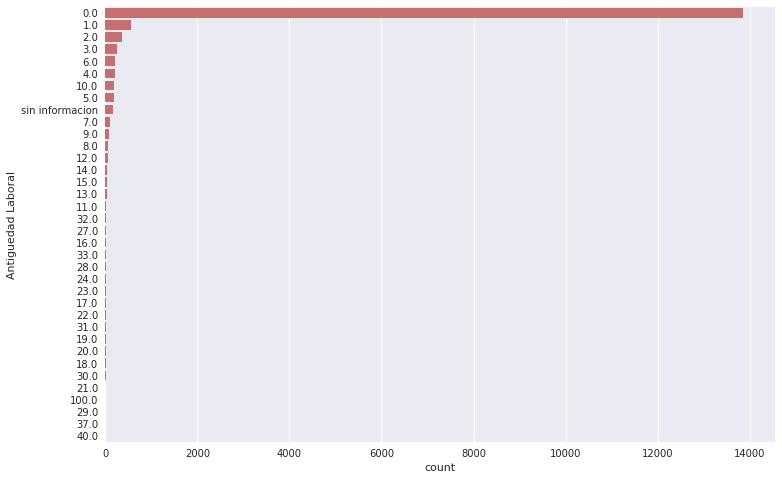

In [60]:
ver_atributo_categorico(cot_mod,'Antiguedad Laboral',log=True)

## 2.2 Direccion

1290 ['Santo Tomas Beket 440, casa 33, Lomas San Sebastian', nan, 'Calle 1 590, Lorenzo Arenas 590', 'Pasaje la Espiga, quilamapu', 'Marina de chile \xa03098', 'Avenida San Sebastián 746 condominio don Esteban casa 05, lomas de san Sebastián. 746 Depto 05', 'Garcia Hurtado de Mendoza 525 Depto 5', 'Camino Al Venado 585', 'Laguna Lo Galindo 813 villa Ensenada 813', 'J. Valdivieso 296 Depto 34 296 Depto 34', 'Los Lirios, pasaje 37 360', 'Avenida Las Terrazas 1546 Depto Terrazas Las Lomas', 'Pasaje San Celso 9388', 'Alfredo Valenzuela 388, Villa Acero 388', 'Desiderio Garcia \xa0Higueras 756', 'Condominio Juan Antonio Varas 1664 Concepcion 1664', 'Quilacoya 9227, Villa Antillanca, Hualpén 9227', 'Lorenzo Arenas Mencia de Los Nidos 195', 'Carmen 110 Depto 216', 'La Quinta 956', 'Moises Amaral 125', 'Calle Santiago, Villa Santiago. 740', 'domingo ortiz de rozas 1470, terrazas las lomas', 'Cochrane 1384', 'Ramon Carrasco 231', 'Galbarino 2360', 'Suarez Mujica 411 Depto 801', 'Francisco de Vi

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


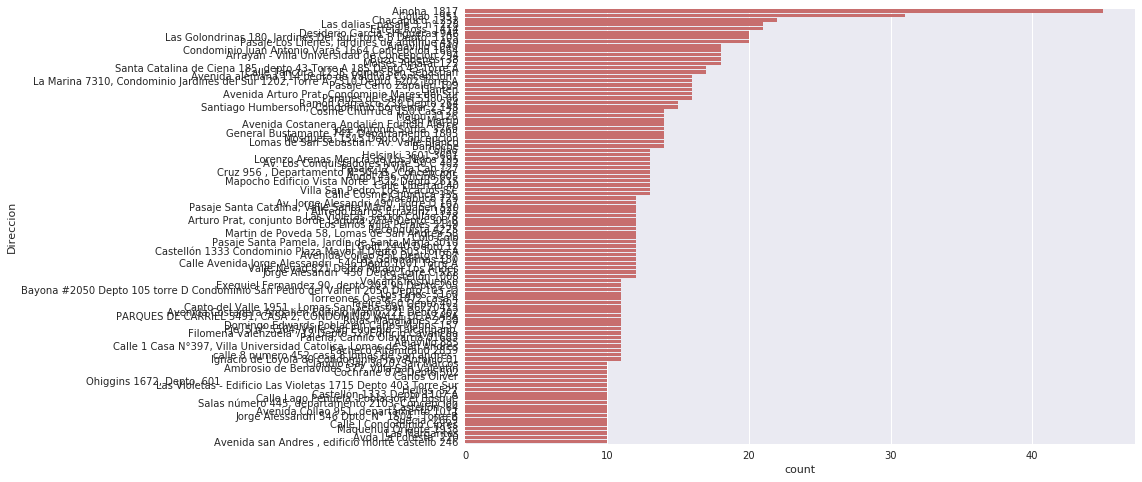

In [61]:
ver_atributo_categorico(cot_mod,'Direccion', log=True, lim=100, limit=True)

Nulos 11384
No nulos 5207
Unicos 1290


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


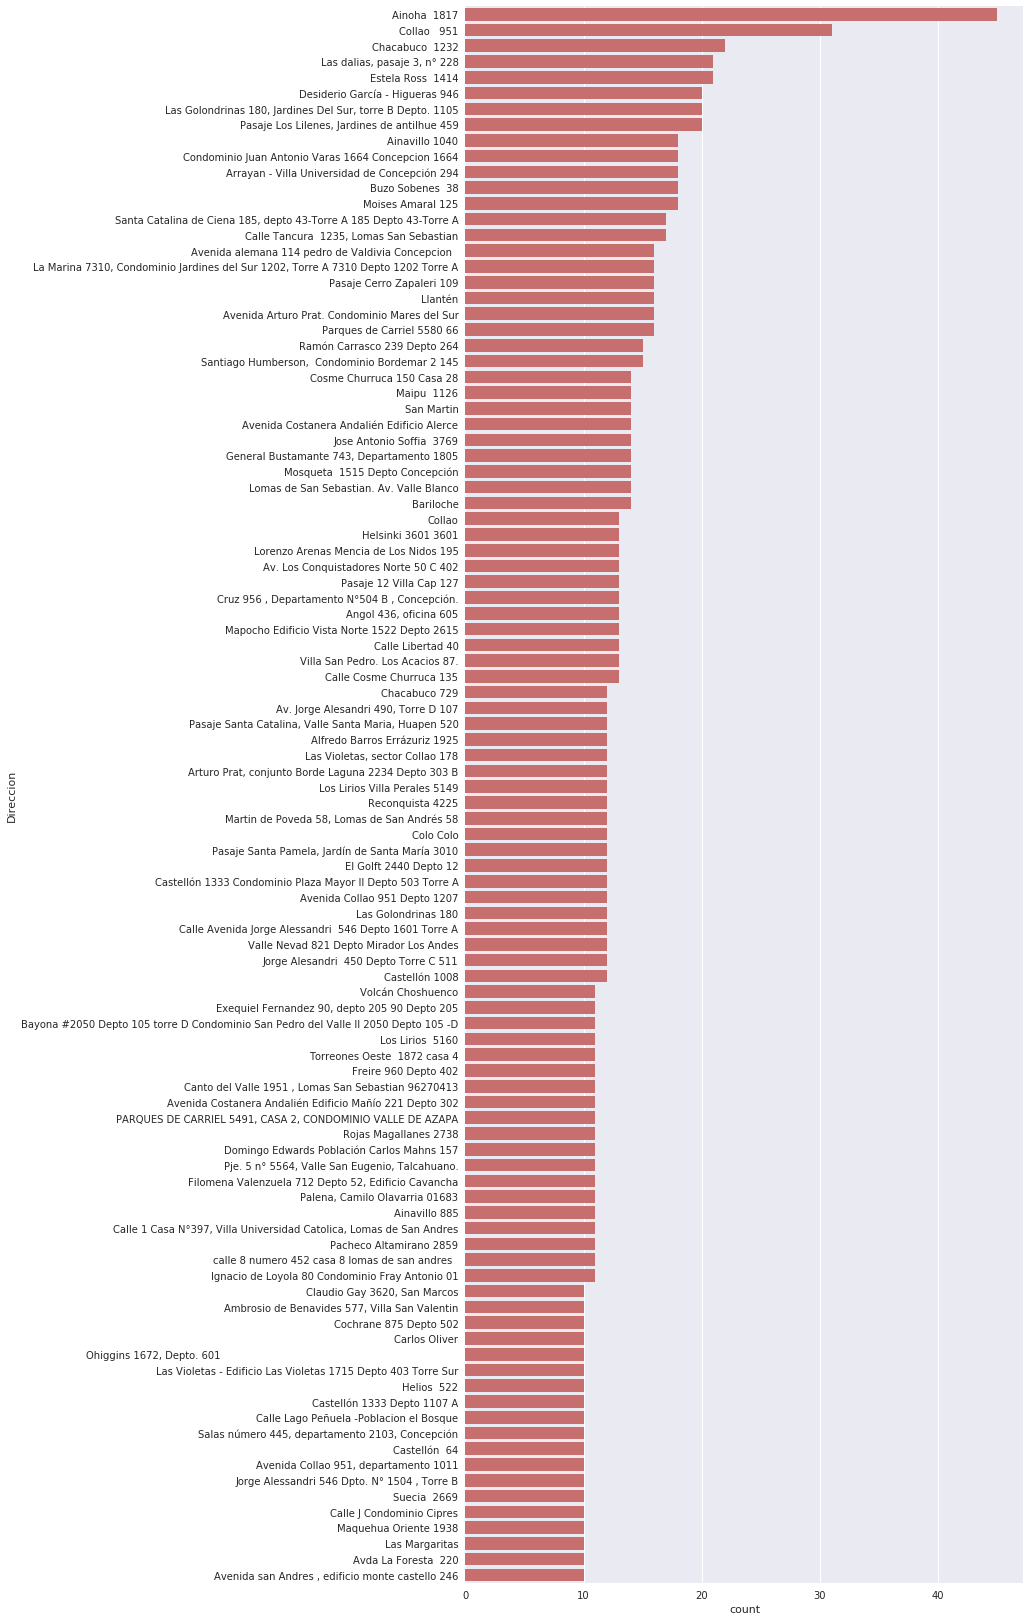

In [62]:
nulos_n_unicos('Direccion')
f = plt.figure(figsize=(10,29))
ver_atributo_categorico(cot_mod,'Direccion', log=False, lim=100, limit=True, f=f)

In [63]:
mask = (cot_mod['Direccion'].str.len() < 7)
print(cot_mod[mask]['Direccion'].shape)
print(cot_mod[mask]['Direccion'])

(32,)
333        ....
448      Collao
449      Collao
450      Collao
1092          .
1245     schaub
3064     Collao
3065     Collao
3067     Collao
4800      Colon
5730       Avda
9640     bayona
9641     bayona
9648     bayona
12574    bayona
12647     Maipu
12682     Maipu
12685     Maipu
12686     Maipu
12692     Maipu
12929    Collao
12930    Collao
13319    Collao
13320    Collao
13321    Collao
13322    Collao
13451     Angol
13471     Angol
13570    Collao
13596    ......
16084      22 0
16171      22 0
Name: Direccion, dtype: object


In [64]:
easy_clean('Direccion')

to_replace.extend(['.', '......'])

pattern_clean('Direccion')


Nulos 11384
Easy Cleaned:  (0, 49)
No nulos 16591


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


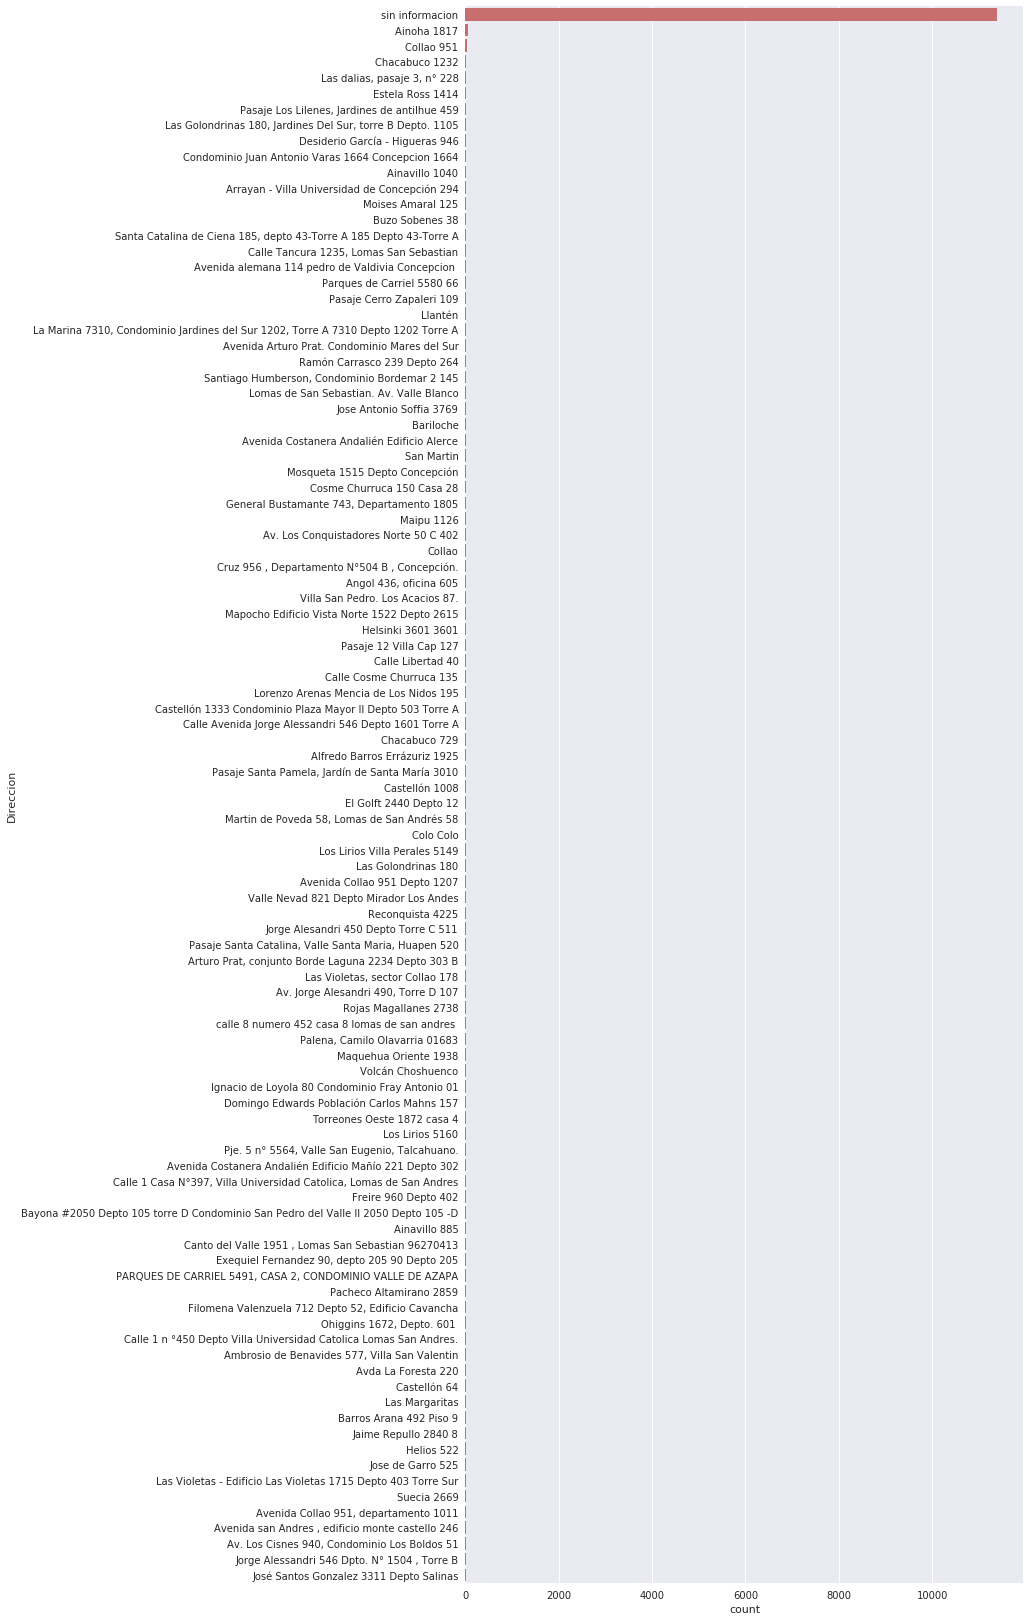

In [65]:
f = plt.figure(figsize=(10,29))
ver_atributo_categorico(cot_mod,'Direccion', log=False, lim=100, limit=True, f=f)

### 1.2.22 Nombre

In [66]:
nulos_n_unicos('Nombre')

Nulos 0
No nulos 16591
Unicos 2480


2481 ['Nelda Del Carmen', 'Cecilia', 'Yeni', 'Maria Mercedes', 'John Rodrigo', 'Zarah', 'Helena', 'Carlos', 'Leslie Andrea', 'Consuelo Ivonne', 'Fabiola Andrea', 'Maria de la Luz', 'Carlos Alberto', 'Alejandro Antonio', 'Cesar Antonio', 'Jose Eduardo', 'Guido Arcides', 'Pilar Andrea', 'Robinson Antonio', 'Marcos Alex', 'Hector', 'María josé', 'Rodolfo', 'Erwin Alejandro', 'Enzo Antonio', 'Ana María', 'Patricio Bladimir', 'Gabriel Alejandro', 'Anibal Antonio', 'Cristian', 'Antonella', 'Claudio', 'Pia', 'Pamela', 'Ktty Alejandra', 'Anselmo', 'Camila', 'Francisco', 'Vanesa', 'Carmen', 'Luis', 'Nicolas', 'Teresa Del Carmen', 'Maria Alejandra', 'Carolina', 'Patricia Angelica', 'Javier Israel', 'Gerardo Andrés', 'Gianinna Fatme', 'Osvaldo Nicolás', 'Claudia', 'Henry', 'Gloria Celina Fernanda', 'Sindy', 'Jordan Sebastian', 'Patricio', 'Alejandra', 'Julia del Carmen', 'Eduardo Fernando', 'Sonia Del Rosario', 'Dante', 'Douglas', 'Joaquin', 'Cynthia Andrea', 'Jean Paul', 'Pedro Eugenio', 'David'

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


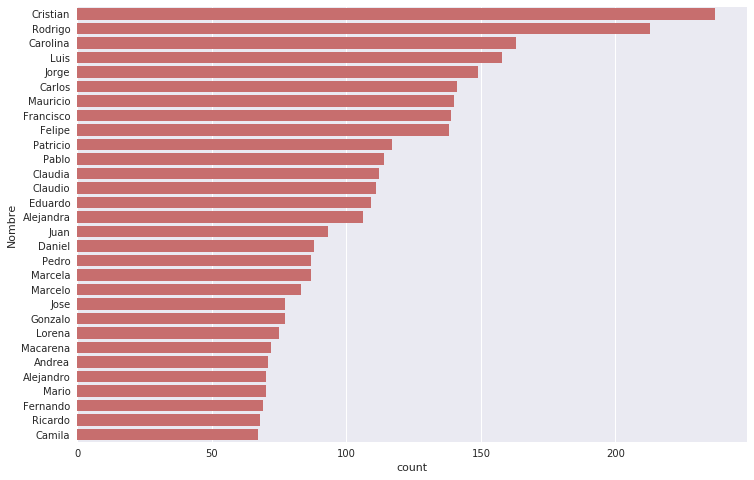

In [67]:
ver_atributo_categorico(cot_all,'Nombre', log=True,limit = True, lim=30)

In [68]:
mask = (cot_mod['Nombre'].str.len() < 3)
print(cot_mod[mask]['Nombre'].shape)
print(cot_mod[mask]['Nombre'])

(4,)
2864      -
2865      .
2866      -
13994    Li
Name: Nombre, dtype: object


In [69]:
easy_clean('Nombre')
to_replace.extend(['-', '.'])

pattern_clean('Nombre')

Nulos 0
Easy Cleaned:  (0, 49)
No nulos 16591


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


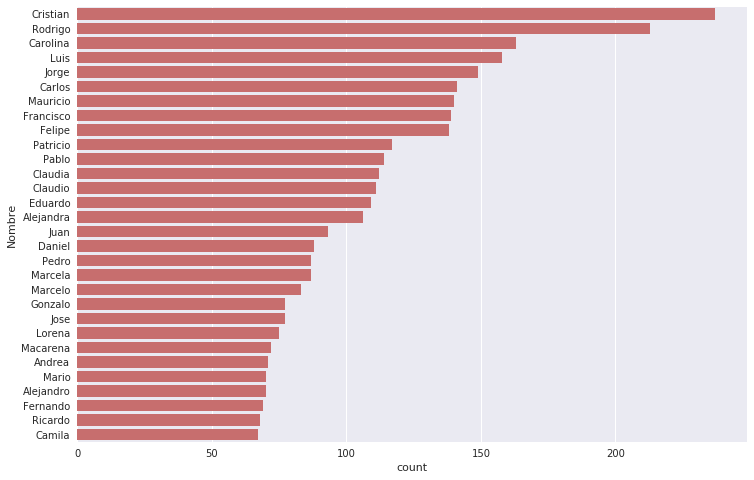

In [70]:
ver_atributo_categorico(cot_mod,'Nombre', limit = True, lim=30)

### 1.2.23 Apellido 1

In [71]:
nulos_n_unicos('Apellido 1')

Nulos 39
No nulos 16552
Unicos 1864


1864 ['Rojas', 'Sepulveda', 'Burgos', 'Torres', 'Fuentes', 'Lobos', 'Villouta', 'Santa María', 'Espinoza', 'Salazar', 'Moreno', 'Polidori', 'Cofre', 'Mardones', 'Soto', 'Paredes', 'Silva', 'Aguilera', 'Reyes', 'Ambiado', 'Gajardo', 'Merino', 'Vejar', 'Daza', 'Lizama', 'Valdes', 'Espinosa', 'Gonzalez', 'Sánchez', 'Gattini', 'Meriño', 'Gutierrez', 'Pincheira', 'Arriagada', 'Garcés', 'Esparza', 'Zamorano', 'Hidalgo', 'Peñailillo', 'Cea', 'Riffo', 'Gaete', 'Jorquera', 'Medina', 'Alarcon', 'Urzua', 'Polanco', 'Osorio', 'Contreras', 'Rebolledo', 'Lopez', 'Garcia', 'Sagredo', 'Uribe', 'Garrido', 'Ordenes', 'Escobar', 'Cifuentes', 'Scarlazetta', 'Inzunza', 'Sanhueza', 'courdurier', 'Cadenas', 'Aranguiz', 'Moraga', 'Garate', 'Belmar', 'Gómez', 'Pache', 'Zagal', 'Bobadilla', 'Figueroa', 'Vega', 'Barriga', 'Sandoval', 'Alcerreca', 'Friedl', 'Arroqui', nan, 'Diaz', 'Gomez', 'Guzman', 'Collao', 'Castro', 'Donoso', 'Chappuzeau', 'Victoriano', 'Castillo', 'Quezada', 'Vivanco', 'Bustos', 'Chavez', 'Na

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


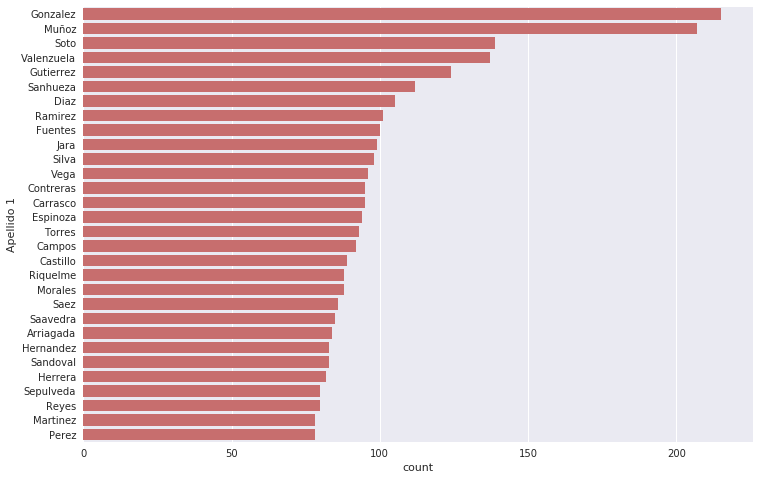

In [72]:
ver_atributo_categorico(cot_mod,'Apellido 1', log=True,limit = True, lim=30)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


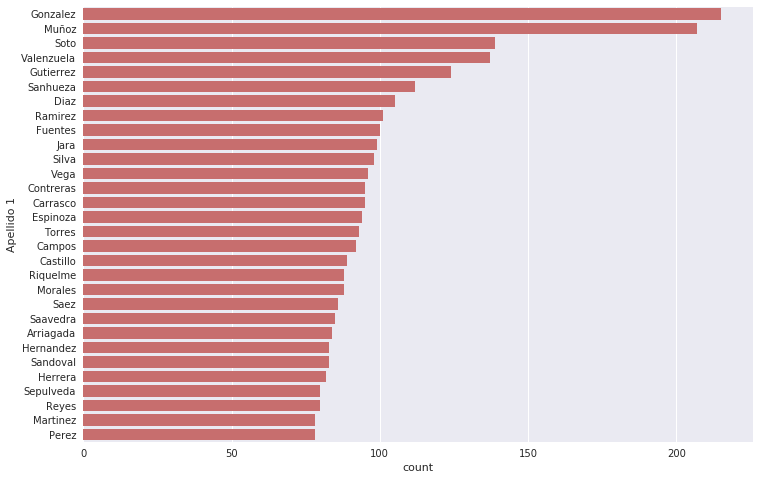

In [73]:
ver_atributo_categorico(cot_mod,'Apellido 1', limit = True, lim=30)

In [74]:
mask = (cot_mod['Apellido 1'].str.len() < 5)
print(cot_mod[mask]['Apellido 1'].shape)
print(cot_mod[mask]['Apellido 1'].tolist())

(1635,)
['Soto', 'Daza', 'Soto', 'Cea', 'Soto', 'Vega', 'Diaz', 'Soto', 'Soto', 'Diaz', 'Saez', 'Hiza', 'Hiza', 'Hiza', 'Vega', 'jara', 'Diaz', 'Diaz', 'Diaz', 'Medi', 'Peña', 'Jara', 'Diaz', 'Pino', 'Pino', 'Pino', 'Cea', 'Cea', 'Unda', 'Unda', 'Saez', 'Saez', 'Saez', 'Saez', 'Saez', 'Saez', 'Saez', 'Saez', 'Saez', 'Saez', 'Saez', 'Saez', 'Saez', 'Saez', 'Saez', 'Saez', 'Romo', 'Romo', 'Romo', 'Diaz', 'Diaz', 'Diaz', 'Diaz', 'Diaz', 'Rios', 'Rios', 'Rios', 'Rios', 'Rios', 'Rios', 'Rios', 'Rios', 'Rios', 'Rios', 'Rios', 'Rios', 'Rios', 'Rios', 'Rios', 'Roa', 'Sims', 'VELA', 'VELA', 'Aedo', 'Peña', 'Lema', 'Lema', 'Lema', 'Lema', 'Lema', 'Lema', 'Lema', 'Lema', 'Unda', 'Jury', 'Jury', 'Diaz', 'Diaz', 'Jaña', 'Jaña', 'Jaña', 'Ruiz', 'Ruiz', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Diez', 'Puga', 'Vega', 'Vega', 'Urra', 'Sazo', 'Sazo', 'Sazo', 'Orue', 'Orue', 'Diaz', 'Cruz', 'Cruz', 'Cruz', 'Ur

In [75]:
easy_clean('Apellido 1')

to_replace.extend(['-', '.'])
pattern_clean('Apellido 1')


Nulos 39
Easy Cleaned:  (0, 49)
No nulos 16591


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


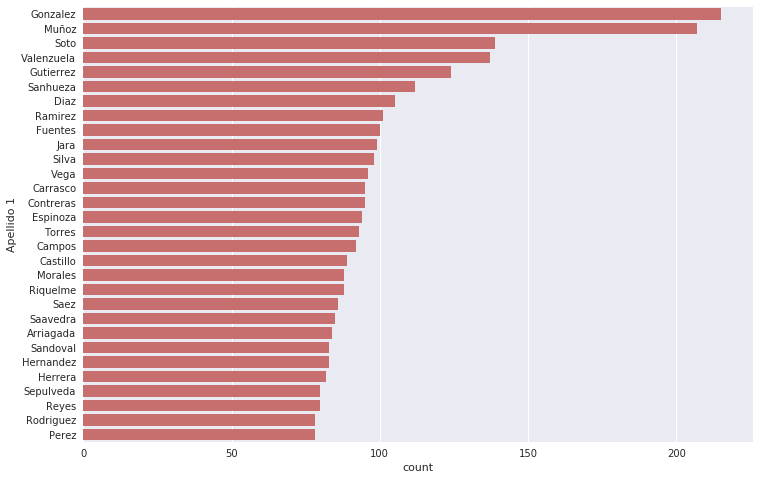

In [76]:
ver_atributo_categorico(cot_mod,'Apellido 1', limit = True, lim=30)

In [77]:
nulos_n_unicos('Apellido 1')

Nulos 0
No nulos 16591
Unicos 1864


### 1.2.23 Apellido 2

In [78]:
nulos_n_unicos('Apellido 2')

Nulos 407
No nulos 16184
Unicos 1664


1664 ['Ulloa', 'Torres', 'Manriquez', 'Martinez', 'Gajardo', 'l', '.', 'Campos', 'Fica', 'Pineda', 'Erle', 'Vega', 'Casanova', 'Villegas', 'Herrera', 'Rodriguez', 'Lopez', 'Oliva', 'Cabezas', 'Figueroa', 'Lobos', 'Sanchez', 'Becerra', 'Reyes', 'Miranda', 'Vergara', 'Marianjel', 'Acuña', '*', 'Paredes', 'Larenas', 'Seguek', 'Olivares', '-', 'Guzman', 'Molina', 'Opazo', 'Vilugrón', '..', 'Esparza', 'Vivanco', 'Silva', 'Brañas', 'Quiroga', 'Mora', 'Rojas', 'Nuñez', 'Lazo', 'Ortiz', 'Sandoval', 'Höger', 'Araya', 'Ramirez', 'Cadenas', 'Vera', 'Contreras', 'Hoffmann', 'Cartes', 'Mahuzier', 'Salaberri', 'Hernandez', 'Flores', 'Ilufin', 'Sorensen', 'Romero', 'Jara', 'Suazo', 'Orellana', 'Navarrete', 'Roman', 'Pinto', 'Cottet', 'Irribarra', 'Lecaros', nan, 'Mella', 'Arevalo', 'Aguilera', 'Rios', 'Bolados', 'Vallejos', 'Maldonado', 'Sanchéz', 'Neira', 'Castillo', 'carter', 'Bobadilla', 'Ortega', 'Avello', 'Carmona', 'Carvallo', 'Valenzuela', 'Revello', 'Adonis', 'Martínez', 'Cifuentes', 'Cabrera

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


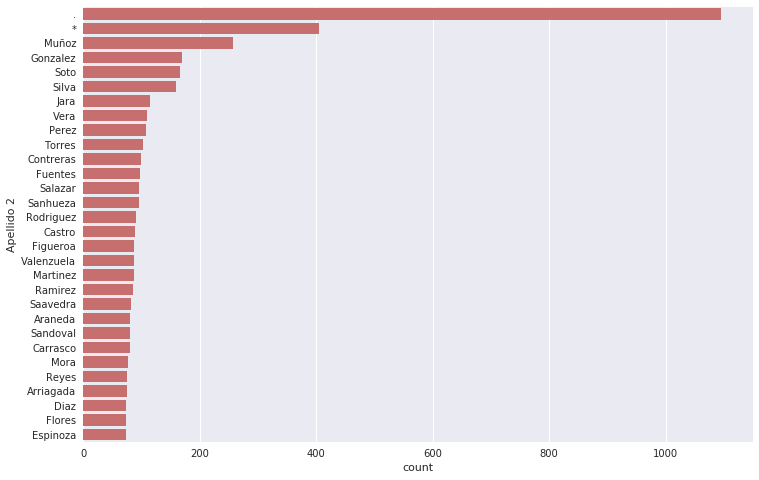

In [79]:
ver_atributo_categorico(cot_mod,'Apellido 2', log=True,limit = True, lim=30)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


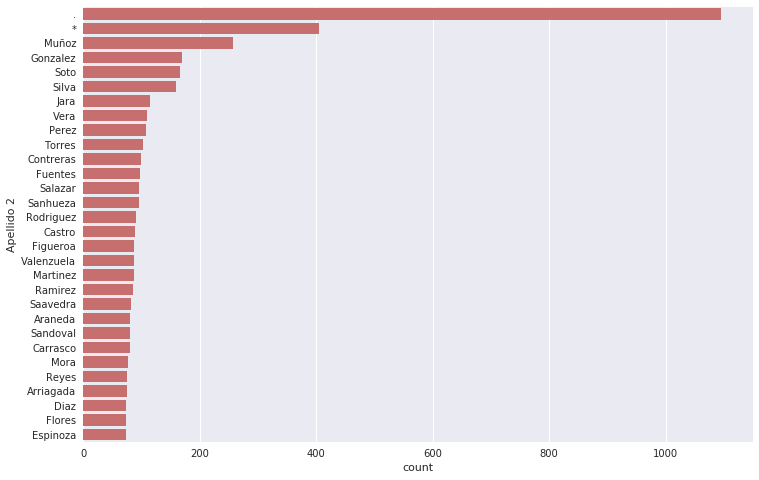

In [80]:
ver_atributo_categorico(cot_mod,'Apellido 2', limit = True, lim=30)

In [81]:
mask = (cot_mod['Apellido 2'].str.len() < 4)
print(cot_mod[mask]['Apellido 2'].shape)
print(cot_mod[mask]['Apellido 2'].tolist())

(1914,)
['l', '.', '.', '.', 'l', '*', '*', '*', '*', '.', '.', '-', '.', '..', '-', '-', '-', '*', '*', '*', '.', '.', '.', '-', '-', '-', '-', '.', '.', 'C', 'C', 'C', 'L', '.', '-', '-', '-', '-', '-', '-', '.', '.', '-', '-', '-', '.', '.', '.', '.', '.', '.', '.', '.', 'A', '*', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'S.', 'S.', 'S.', '.', '.', '.', 'I.', 'I.', 'I.', '.', '.', '.', 'R.', 'R.', 'G', 'G', 'L.', 'P.', 'T.', 'T.', 'T.', '.', '.', '.', '*', '.', '.', '.', '.', '.', '.', '.', 'L', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '*', '*', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '*', '*', '*', '*', '.', '.', '.', 'K', 'K', 'K', '.', '.', '.', '.', 'G.', 'G.', 'G.', 'G.', 'G.', 'G.', 'G.', 'G.', 'G.', 'G.

In [82]:
easy_clean('Apellido 2')

to_replace.extend(['-', '.', '..', '...', '*', '+', 'mmm'])

pattern_clean('Apellido 2')


Nulos 407
Easy Cleaned:  (0, 49)
No nulos 16591


Nulos 0
No nulos 16591
Unicos 1657


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


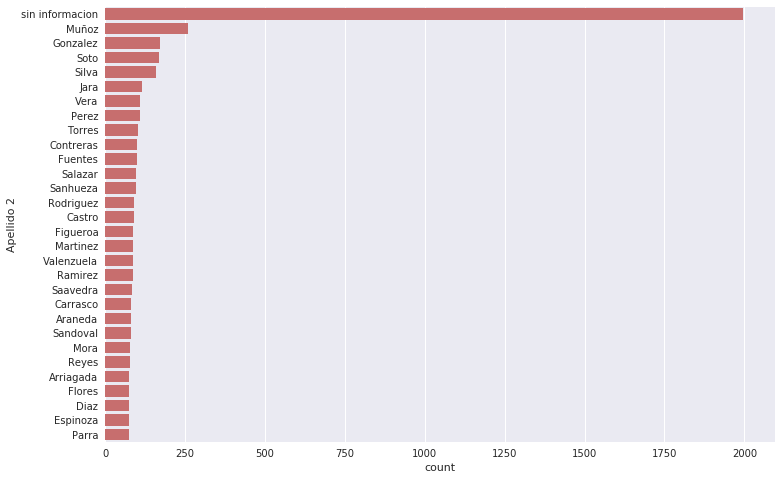

In [83]:
nulos_n_unicos('Apellido 2')
ver_atributo_categorico(cot_mod,'Apellido 2', limit = True, lim=30)

### 1.2.24 Telefono

In [84]:
nulos_n_unicos('Telefono')

Nulos 14597
No nulos 1994
Unicos 590


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


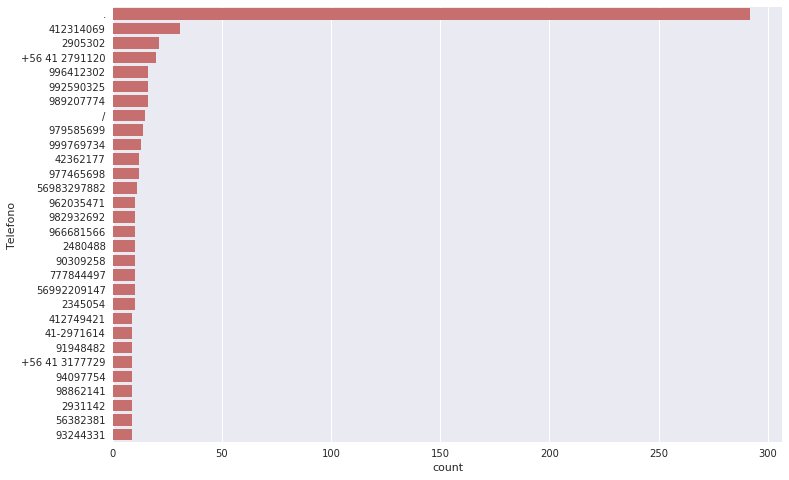

In [85]:
ver_atributo_categorico(cot_mod,'Telefono', limit = True, lim=30)

In [86]:
mask = (cot_mod['Telefono'].str.len() < 4)
print(cot_mod[mask]['Telefono'].shape)
print(cot_mod[mask]['Telefono'].tolist())

(314,)
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.

In [87]:
easy_clean('Telefono')
to_replace.extend(['-', '.', '..', '...', '*', '+', 'mmm', '/', 'x'])

pattern_clean('Telefono')


Nulos 14597
Easy Cleaned:  (0, 49)
No nulos 16591


0
587


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


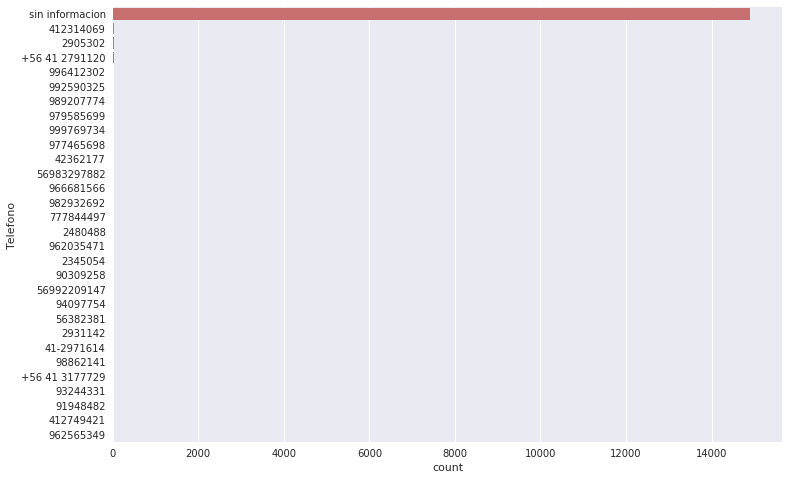

In [88]:
print(cot_mod['Telefono'].isnull().sum())
print(cot_mod['Telefono'].nunique())
ver_atributo_categorico(cot_mod,'Telefono', limit = True, lim=30)

### 1.2.25 Celular

In [89]:
nulos_n_unicos('Celular')

Nulos 38
No nulos 16553
Unicos 6037


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


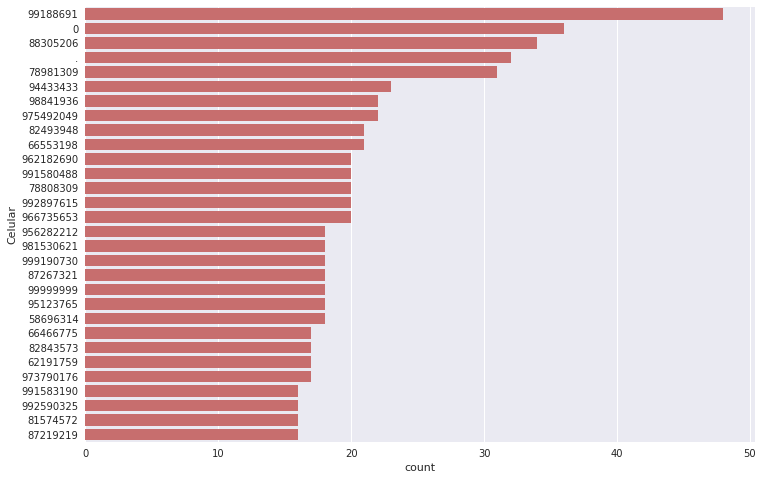

In [90]:
ver_atributo_categorico(cot_mod,  'Celular', log=False, limit = True, lim=30)

In [91]:
mask = (cot_mod['Celular'].str.len() < 6)
print(cot_mod[mask]['Celular'].shape)
print(cot_mod[mask]['Celular'].tolist())

(36,)
['.', '...', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'xxxxx', '-', '...', '.', '.', '.', '.']


In [92]:
easy_clean('Celular')
to_replace.extend(['-', '.', '..', '...', 
              '*', '+', 'mmm', '/', 'x', 
              '...................', '...........', 'xxxxx', '0'])
pattern_clean('Celular')


Nulos 38
Easy Cleaned:  (0, 49)
No nulos 16591


0
6031


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


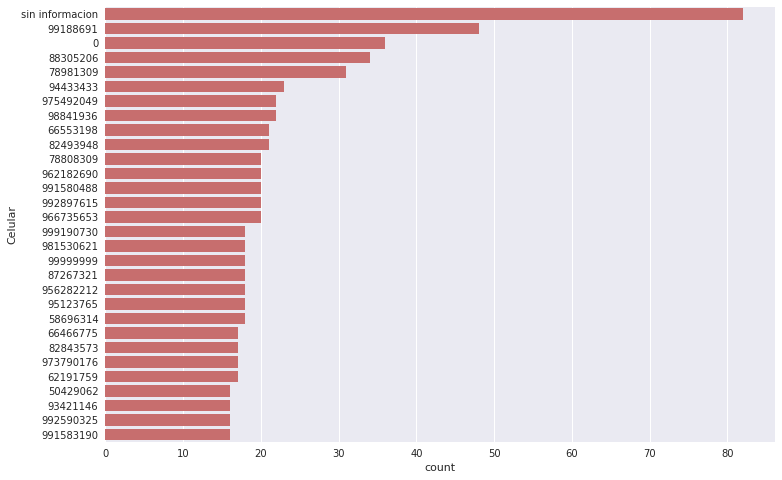

In [93]:
print(cot_mod['Celular'].isnull().sum())
print(cot_mod['Celular'].nunique())
ver_atributo_categorico(cot_mod, 'Celular', limit = True, lim=30)

### 1.2.26 Nombre Completo

In [94]:
nulos_n_unicos('Nombre Completo')

Nulos 0
No nulos 16591
Unicos 6178


6178 ['Nelda Del Carmen Rojas Ulloa', 'Cecilia Sepulveda Torres', 'Yeni Burgos Manriquez', 'Maria Torres Martinez', 'John Rodrigo Fuentes Gajardo', 'Zarah Lobos l', 'Helena Villouta .', 'Carlos Santa María .', 'Leslie Andrea Espinoza Campos', 'Consuelo Ivonne Salazar Fica', 'Fabiola Andrea Moreno Pineda', 'Maria de la Luz Polidori Erle', 'Carlos Alberto Cofre Vega', 'Alejandro Antonio Mardones Casanova', 'Cesar Antonio Soto Villegas', 'Jose Eduardo Paredes Herrera', 'Guido Arcides Silva Rodriguez', 'Pilar Andrea Aguilera Lopez', 'Robinson Antonio Reyes Oliva', 'Marcos Alex \xa0Ambiado Cabezas', 'Hector Gajardo Figueroa', 'María josé Merino Lobos', 'Rodolfo \xa0Bejar Sanchez', 'Erwin Alejandro Daza Becerra', 'Enzo Antonio Lizama Reyes', 'Ana María Valdes Miranda', 'Patricio Bladimir Espinosa Vergara', 'Gabriel Alejandro Gonzalez Marianjel', 'Anibal Antonio \xa0Sánchez Acuña', 'Cristian Vejar *', 'Antonella Gattini *', 'Claudio Meriño .', 'Pia Gutierrez Paredes', 'Pamela Pincheira \xa0La

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


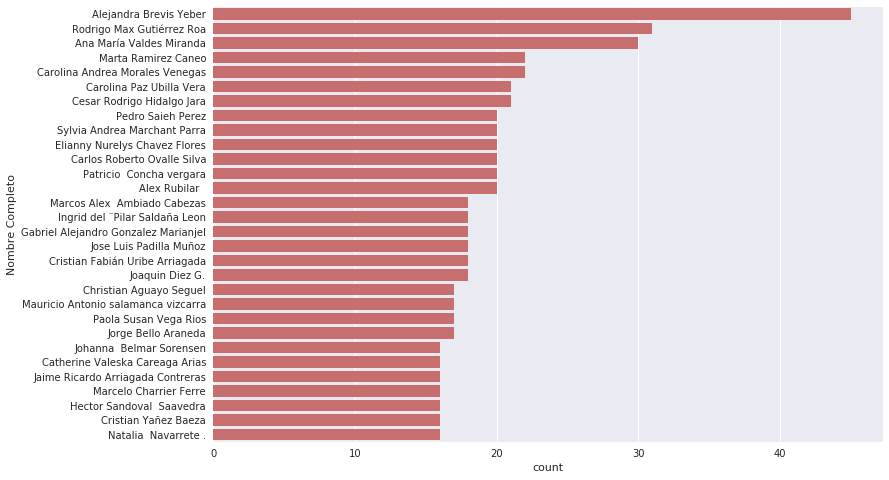

In [95]:
ver_atributo_categorico(cot_mod,  'Nombre Completo', log=True, limit = True, lim=30)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


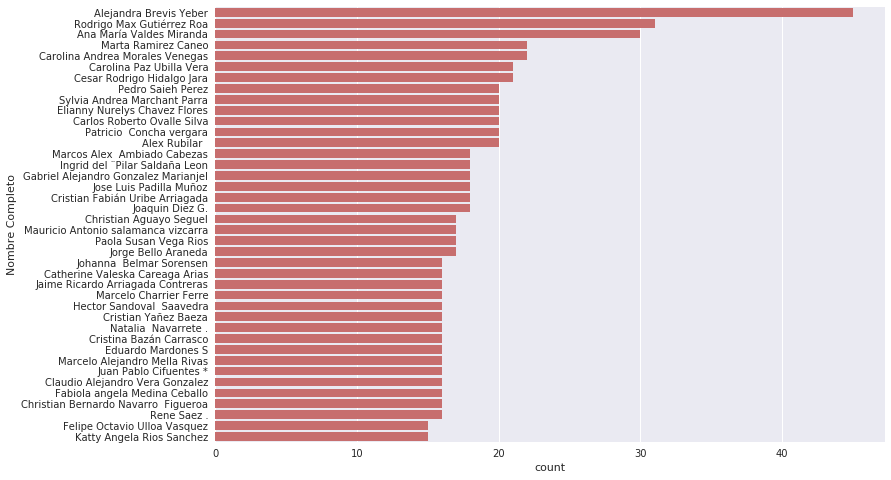

In [96]:
ver_atributo_categorico(cot_mod,  'Nombre Completo', log=False, limit = True, lim=40)

In [97]:
mask = (cot_mod['Nombre Completo'].str.len() < 10)
print(cot_mod[mask]['Nombre Completo'].shape)
print(cot_mod[mask]['Nombre Completo'].tolist())

(8,)
['- \xa0', '. . .', '- \xa0', 'Ana Claro', 'Wenjin Li', 'Wenjin Li', 'Li Ma .', 'Ana Claro']


In [98]:
easy_clean('Nombre Completo')

to_replace.extend (['-', '.', '..', '...', 
              '*', '+', 'mmm', '/', 'x', 
              '- \xa0', '. . .', 'xxxxx'])
pattern_clean('Nombre Completo')

Nulos 0
Easy Cleaned:  (0, 49)
No nulos 16591


In [99]:
mask = (cot_mod['Nombre Completo'].str.len() < 10)
print(cot_mod[mask]['Nombre Completo'].shape)
print(cot_mod[mask]['Nombre Completo'].tolist())

(14,)
['SuizCorp ', 'Ana Claro', 'Wenjin Li', 'Wenjin Li', 'Qing Li .', 'Qing Li .', 'Qing Li .', 'Qing Li .', 'Qing Li .', 'Li Ma .', 'Ana Claro', 'PIA MOYA ', 'PIA MOYA ', 'PIA MOYA ']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


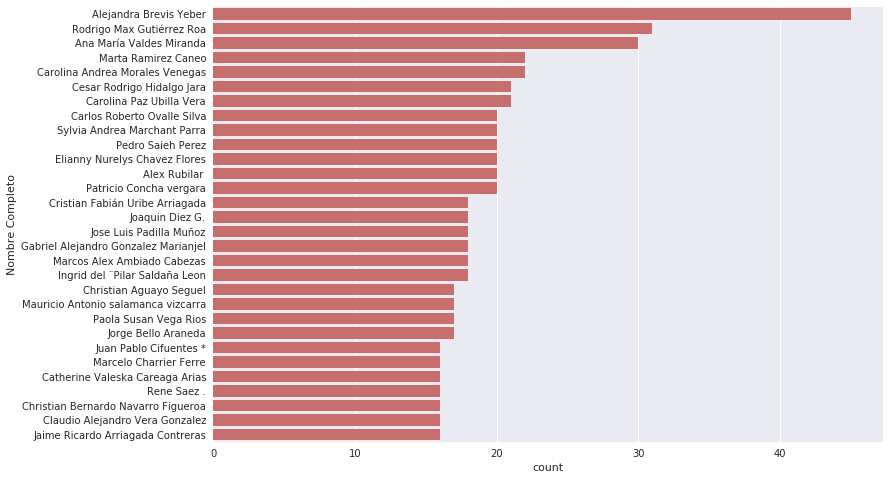

In [100]:
ver_atributo_categorico(cot_mod,  'Nombre Completo', log=False, limit = True, lim=30)

### 1.2.26 Sexo

In [101]:
nulos_n_unicos('Sexo')

Nulos 1869
No nulos 14722
Unicos 3


3 ['Femenino', 'Masculino', nan, 'Sin Información']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


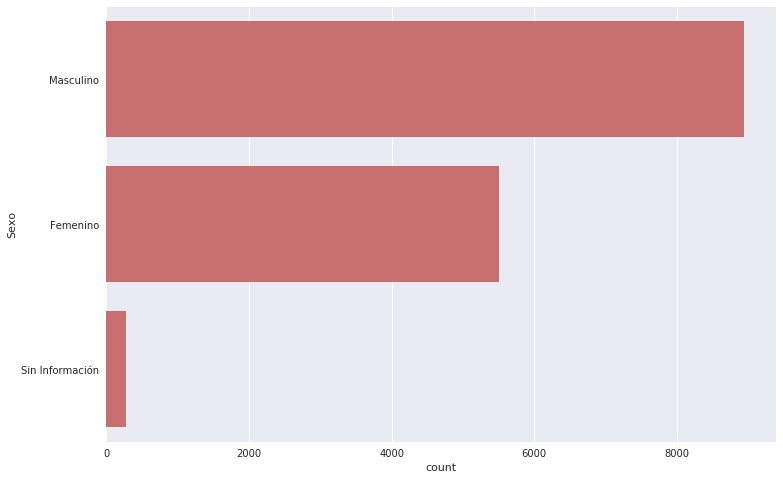

In [102]:
ver_atributo_categorico(cot_mod,  'Sexo', log=True, limit = True, lim=30)

In [103]:
easy_clean('Sexo')
pattern_clean('Sexo')

cot_mod.Sexo.replace(['Sin Información'],REPLACE_WITH, inplace=True)

Nulos 1869
Easy Cleaned:  (0, 49)
No nulos 16591


3 ['Femenino', 'Masculino', 'sin informacion']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


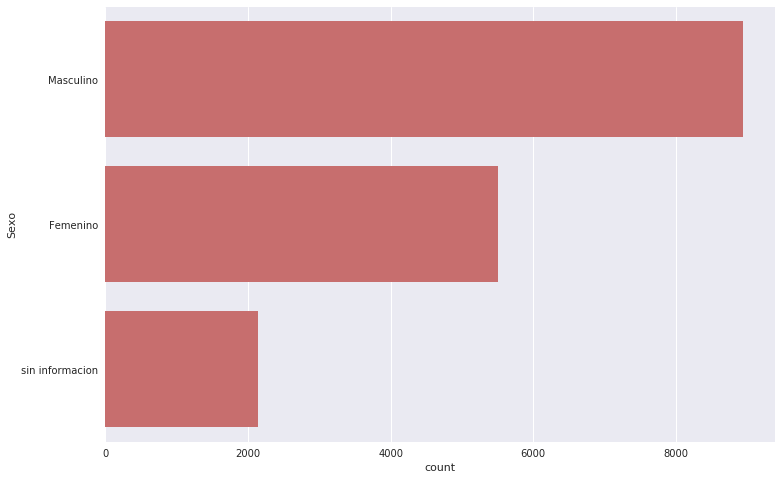

In [104]:
ver_atributo_categorico(cot_mod,  'Sexo', log=True, limit = True, lim=30)

### 1.2.26 Giro

In [105]:
nulos_n_unicos('Giro')

Nulos 16558
No nulos 33
Unicos 20


20 [nan, 'Transporte de carga por carretera', 'Importadora y Comercializadora', 'Inversiones', 'Seguros', 'Comercializadora de aluminios y vidrios', 'Inmobiliaria', 'Servicios', 'Servicios Medicos', 'Inmobiliario', 'Ingenieria', 'Imv Cia LTDA.', 'Inmobiliaria Divesa ltda.', 'comercializadora', 'Obras Civiles', 'Constructora', 'comercializadora utiles domesticos', 'Sociedad de Inversion', 'Sociedad de Inversiones', 'industrial', 'TRASPORTE']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


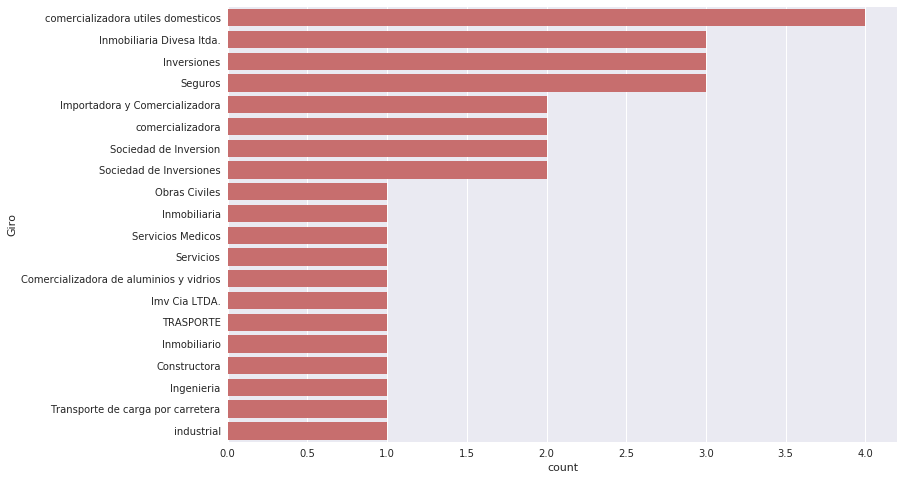

In [106]:
ver_atributo_categorico(cot_mod,'Giro', log=True, limit = True, lim=30)

In [107]:
easy_clean('Giro')

Nulos 16558
Easy Cleaned:  (0, 49)
No nulos 16591


21 ['sin informacion', 'Transporte de carga por carretera', 'Importadora y Comercializadora', 'Inversiones', 'Seguros', 'Comercializadora de aluminios y vidrios', 'Inmobiliaria', 'Servicios', 'Servicios Medicos', 'Inmobiliario', 'Ingenieria', 'Imv Cia LTDA.', 'Inmobiliaria Divesa ltda.', 'comercializadora', 'Obras Civiles', 'Constructora', 'comercializadora utiles domesticos', 'Sociedad de Inversion', 'Sociedad de Inversiones', 'industrial', 'TRASPORTE']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


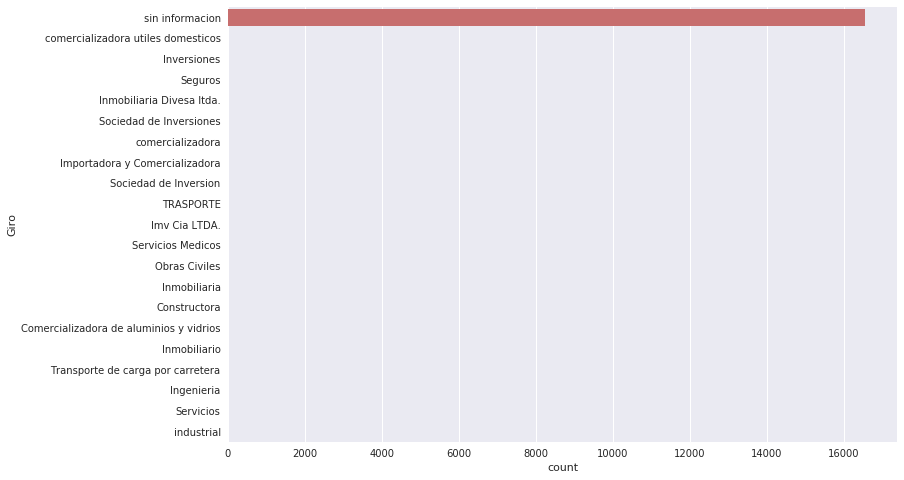

In [108]:
ver_atributo_categorico(cot_mod,'Giro', log=True, limit = True, lim=30)

### 1.2.26 Situacion Laboral

In [109]:
nulos_n_unicos('Situacion Laboral')

Nulos 12795
No nulos 3796
Unicos 3


3 [nan, 'Sin Información', 'Dependiente', 'Independiente']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


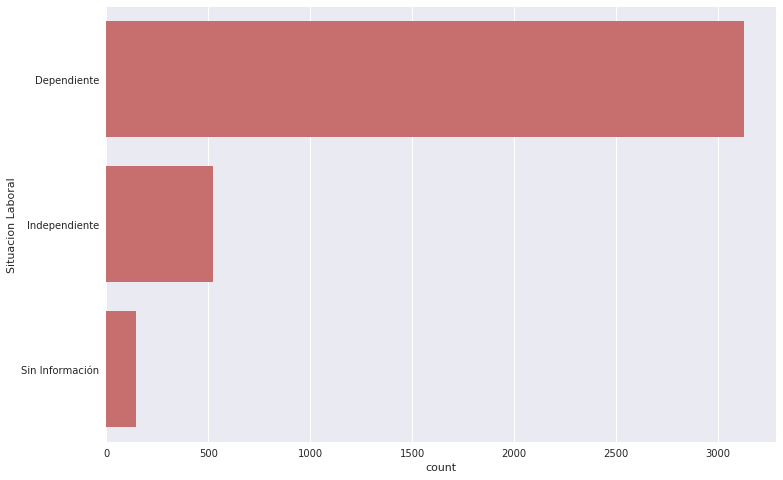

In [110]:
ver_atributo_categorico(cot_all,'Situacion Laboral', log=True)

In [111]:
easy_clean('Situacion Laboral')
pattern_clean('Situacion Laboral')

Nulos 12795
Easy Cleaned:  (0, 49)
No nulos 16591


4 ['sin informacion', 'Sin Información', 'Dependiente', 'Independiente']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


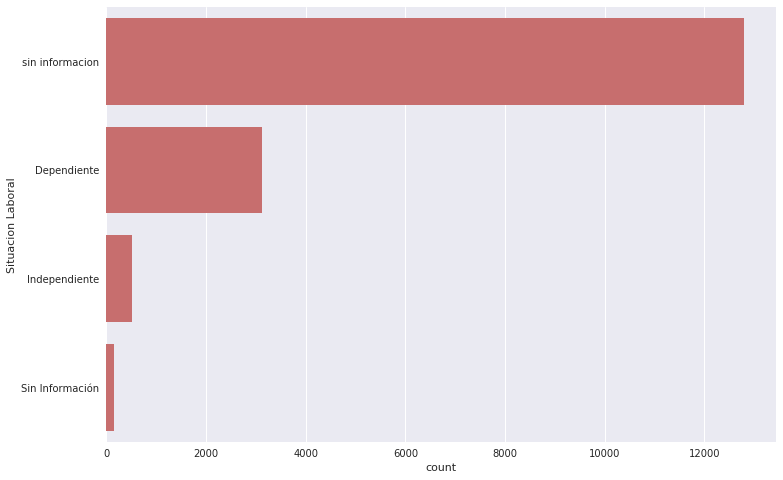

In [112]:
ver_atributo_categorico(cot_mod,'Situacion Laboral', log=True)

### 1.2.26 Rango Edad

In [113]:
nulos_n_unicos('Rango Edad')

Nulos 1979
No nulos 14612
Unicos 7


7 ['41-50', '31-40', 'Sin Información', '20-30', '51-60', nan, '61+', '15-19']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


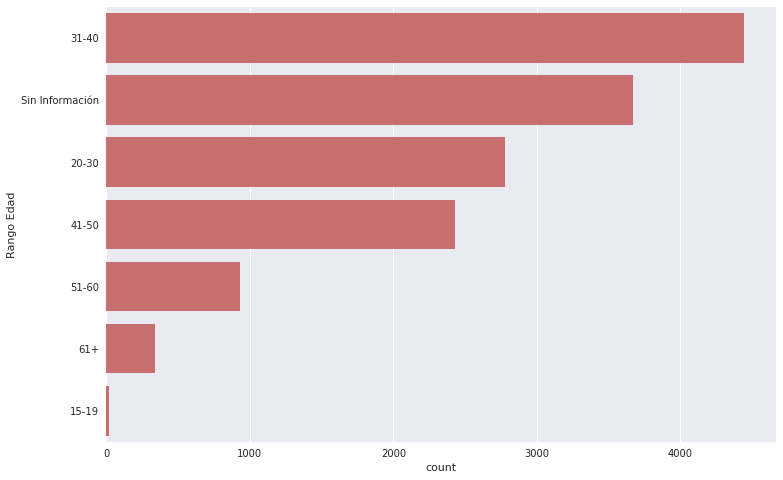

In [114]:
ver_atributo_categorico(cot_mod,'Rango Edad', log=True)

In [115]:
easy_clean('Rango Edad')
pattern_clean('Rango Edad')

Nulos 1979
Easy Cleaned:  (0, 49)
No nulos 16591


8 ['41-50', '31-40', 'Sin Información', '20-30', '51-60', 'sin informacion', '61+', '15-19']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


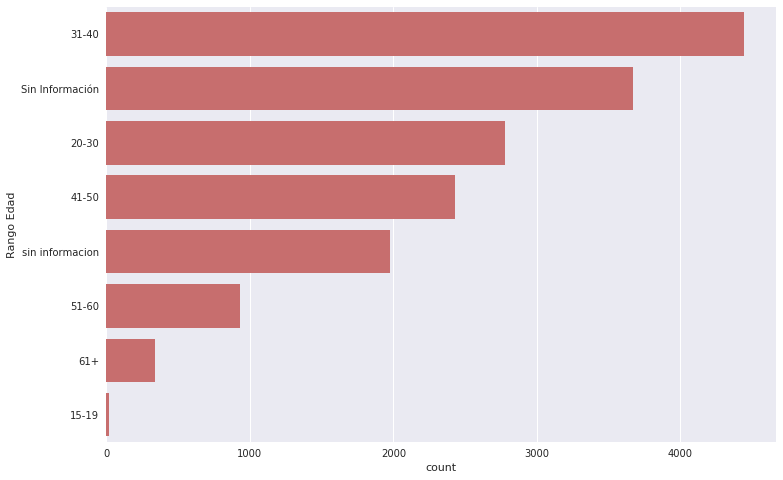

In [116]:
ver_atributo_categorico(cot_mod,'Rango Edad', log=True)

### 1.2.26 Fecha Nacimiento

In [117]:
nulos_n_unicos('Fecha Nacimiento')

Nulos 12701
No nulos 3890
Unicos 840


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


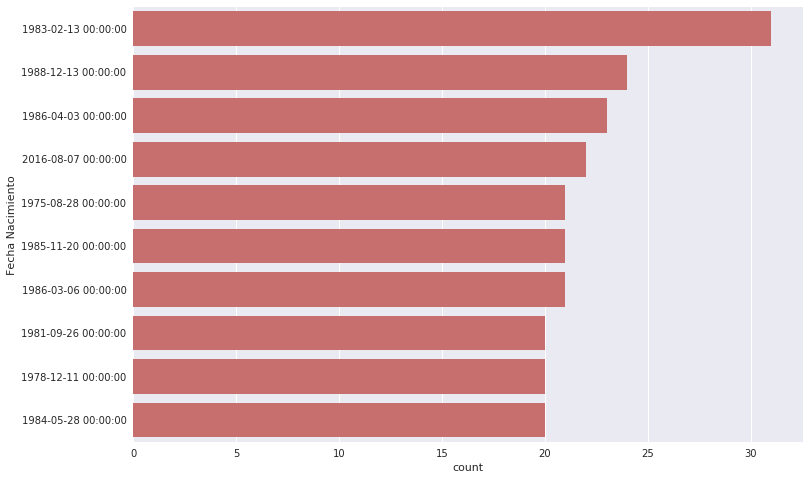

In [118]:
ver_atributo_categorico(cot_mod,'Fecha Nacimiento', log=False, limit=True, lim=10)

In [119]:
# mask = (cot_mod['Fecha Nacimiento'].str.len() < 10)
# print(cot_mod[mask]['Fecha Nacimiento'].shape)
# print(cot_mod[mask]['Fecha Nacimiento'].tolist())

In [120]:
easy_clean('Fecha Nacimiento')

Nulos 12701
Easy Cleaned:  (0, 49)
No nulos 16591


### 1.2.26 Valor Final Venta

In [121]:
nulos_n_unicos('Valor Final Venta')

Nulos 44
No nulos 16547
Unicos 2539


In [122]:
print(cot_mod[cot_mod['Valor Final Venta'] == 0]['Valor Final Venta'].count())

1


In [123]:
print(cot_mod[cot_mod['Valor Final Venta'] > 0]['Valor Final Venta'].describe())

count    16546.000000
mean      4151.013886
std       2091.113496
min        295.000000
25%       3411.000000
50%       3928.250000
75%       4351.000000
max      29400.000000
Name: Valor Final Venta, dtype: float64


Text(0.5,0,'Valor Final Venta (UF)')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


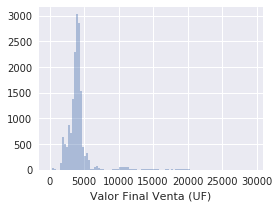

In [37]:
# ver_atributo_categorico(cot_mod,'Valor Final Venta', log=False)
f = plt.figure(figsize=(4,3))
sb.distplot(cot_mod['Valor Final Venta'].dropna(), kde=False, bins=100);
plt.xlabel('Valor Final Venta (UF)')

In [125]:
cot_mod['Valor Final Venta'].fillna(0, inplace=True)

In [126]:
nulos_n_unicos('Valor Final Venta')

Nulos 0
No nulos 16591
Unicos 2539


### 1.2.26 Descuentos

In [127]:
cot_mod.Descuentos.unique()

array([0.00000e+00, 4.01000e+01, 5.01300e+01, 1.74550e+02, 2.05500e+02,
       2.05550e+02, 1.52900e+02, 2.68000e+02, 1.46797e+03, 1.29318e+03,
       1.43640e+03, 4.98000e+02, 2.00470e+03, 6.32000e+02, 3.36000e+02,
       2.93000e+02,         nan, 3.00000e+02, 9.37800e+01, 1.53080e+02,
       1.71660e+02, 1.02800e+02, 1.03820e+02, 5.57200e+01, 1.06440e+02,
       7.51500e+01, 8.39100e+01, 7.96000e+01, 7.65000e+01, 7.54000e+01,
       8.43000e+01, 7.64000e+01, 7.22000e+01, 8.01000e+01, 7.77000e+01,
       7.68000e+01, 7.69000e+01, 8.60000e+01, 7.66000e+01, 8.53000e+01,
       6.99000e+01, 7.71000e+01, 7.67000e+01, 7.25000e+01, 8.58000e+01,
       7.23000e+01, 6.96000e+01, 8.33000e+01, 8.38000e+01, 8.47000e+01,
       7.55000e+01, 8.28000e+01, 6.97000e+01, 7.50000e+01, 4.23500e+01,
       4.12000e+01, 3.77000e+01, 3.48500e+01, 3.98000e+01, 3.84000e+01,
       3.48000e+01, 8.30000e+01, 7.57000e+01, 8.40000e+01, 8.84000e+01,
       8.00000e+01, 7.85000e+01, 7.44000e+01, 2.00000e+00, 8.790

In [128]:
nulos_n_unicos('Descuentos')

Nulos 44
No nulos 16547
Unicos 339


In [129]:
print(cot_mod[cot_mod.Descuentos > 0]['Descuentos'].describe())

count    2180.000000
mean      178.788280
std        98.638918
min         2.000000
25%        86.600000
50%       205.000000
75%       219.000000
max      2004.700000
Name: Descuentos, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


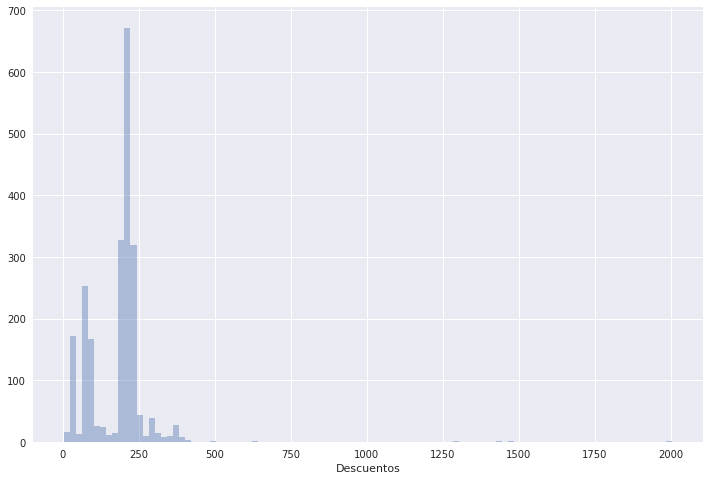

In [130]:
f = plt.figure(figsize=(12,8))
sb.distplot(cot_mod[cot_mod.Descuentos > 0]['Descuentos'].dropna(), kde=False, bins=100);

In [131]:
# print(cot_mod[cot_mod['Descuentos'].isnull()].shape)
# cot_mod['Descuentos'].fillna('Sin Información', inplace=True)
# print(cot_mod[cot_mod['Descuentos'].isnull()].shape)

In [132]:
cot_mod['Descuentos'].fillna('0', inplace=True)
nulos_n_unicos('Descuentos')

Nulos 0
No nulos 16591
Unicos 340


### 1.2.26 Nacionalidad

In [133]:
nulos_n_unicos('Nacionalidad')

Nulos 11744
No nulos 4847
Unicos 8


8 [nan, 'Chilena', 'Venezolana', 'Colombiana', 'Alemana', 'Sin Información', 'Extranjera', 'Boliviana', 'China']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


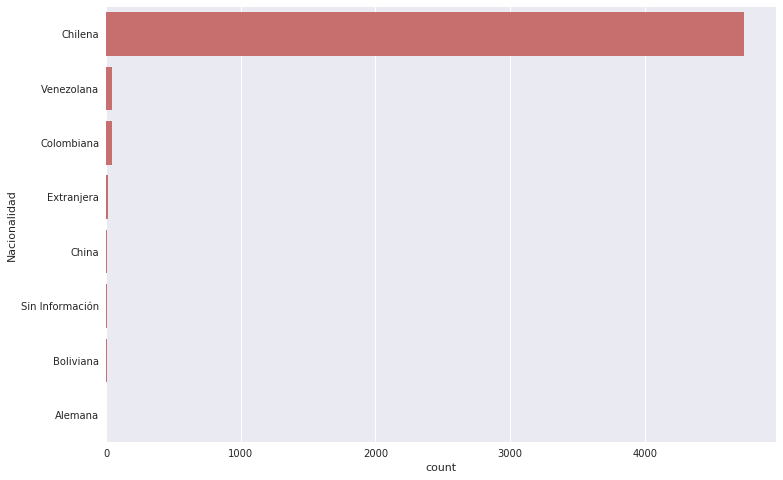

In [134]:
ver_atributo_categorico(cot_mod,'Nacionalidad', log=True)

In [135]:
easy_clean('Nacionalidad')
pattern_clean('Nacionalidad')

Nulos 11744
Easy Cleaned:  (0, 49)
No nulos 16591


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


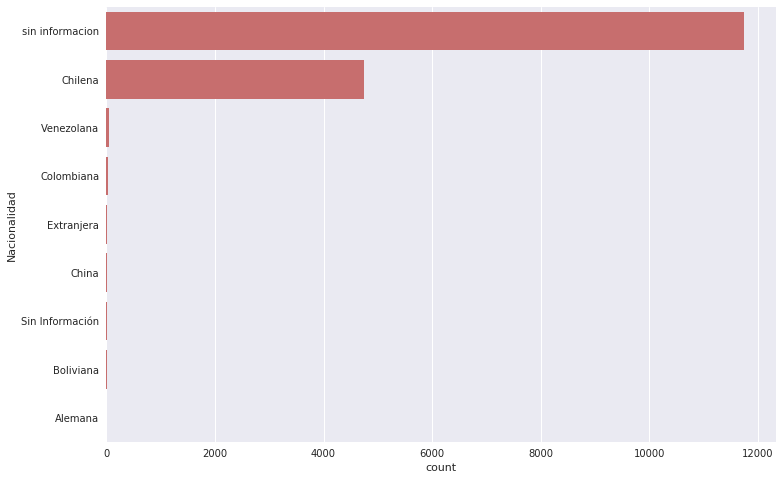

In [136]:
ver_atributo_categorico(cot_mod,'Nacionalidad')

### 1.2.26 Productos

In [137]:
nulos_n_unicos('Productos')

Nulos 83
No nulos 16508
Unicos 3534


In [138]:
# ver_atributo_categorico(cot_mod,'Nacionalidad', log=False)

In [139]:
easy_clean('Productos')

Nulos 83
Easy Cleaned:  (0, 49)
No nulos 16591


### 1.2.26 Presencial

In [140]:
nulos_n_unicos('Presencial')

Nulos 2027
No nulos 14564
Unicos 2


2 ['Si', 'No', nan]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


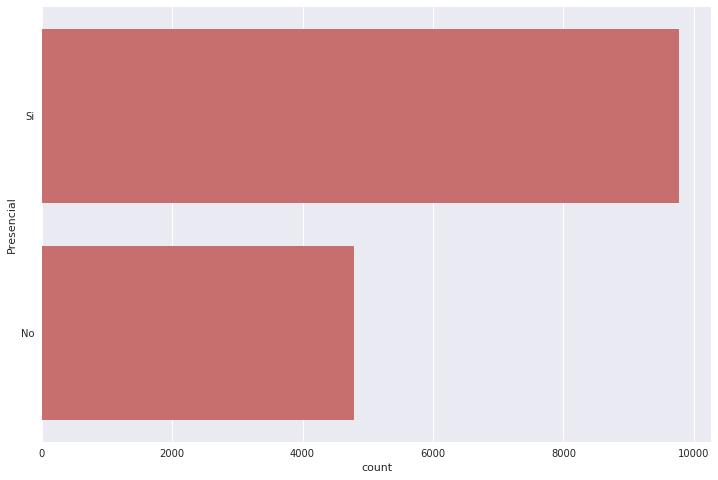

In [141]:
ver_atributo_categorico(cot_mod,'Presencial', log=True)

In [142]:
easy_clean('Presencial')

Nulos 2027
Easy Cleaned:  (0, 49)
No nulos 16591


3 ['Si', 'No', 'sin informacion']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


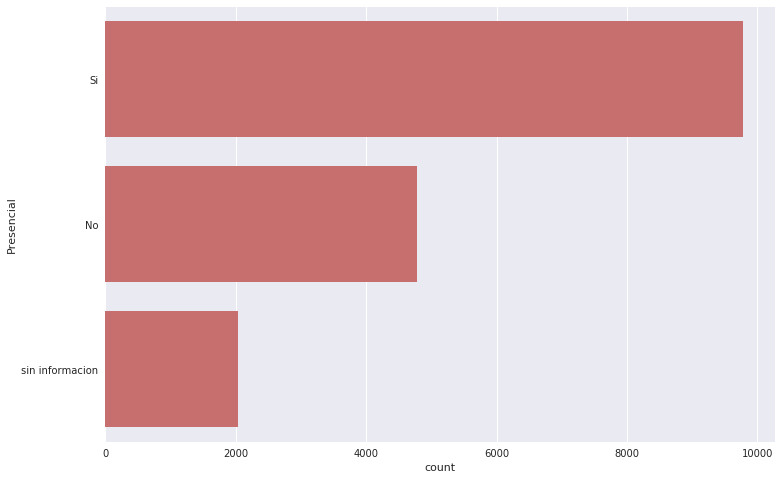

In [143]:
ver_atributo_categorico(cot_mod,'Presencial', log=True)

### 1.2.26 Remoto

In [144]:
nulos_n_unicos('Remoto')

Nulos 3310
No nulos 13281
Unicos 2


2 ['No', 'Si', nan]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


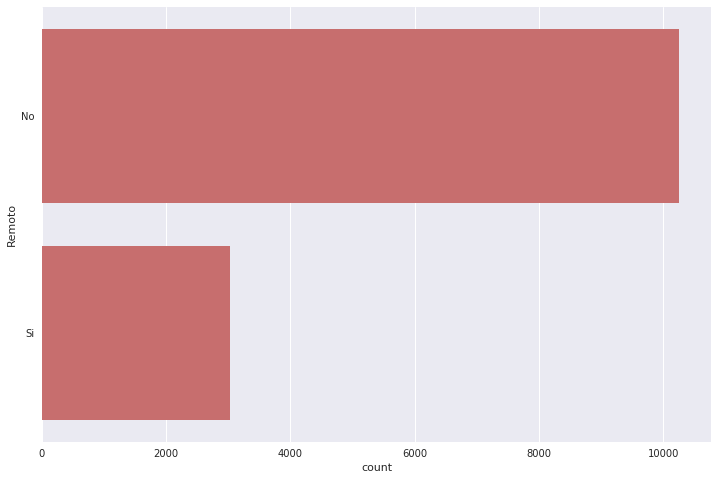

In [145]:
ver_atributo_categorico(cot_mod,'Remoto', log=True)

In [146]:
easy_clean('Remoto')

Nulos 3310
Easy Cleaned:  (0, 49)
No nulos 16591


3 ['No', 'Si', 'sin informacion']


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


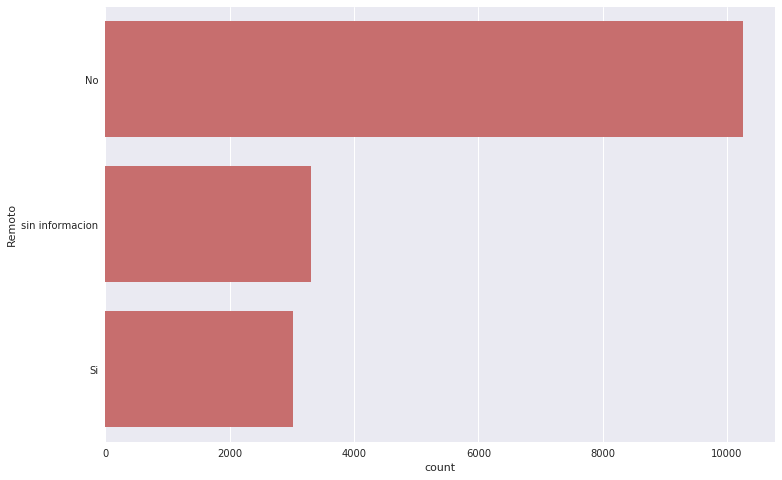

In [147]:
ver_atributo_categorico(cot_mod,'Remoto', log=True)

### 1.2.26 Total Productos

In [148]:
nulos_n_unicos('Total Productos')

Nulos 30
No nulos 16561
Unicos 2195


In [149]:
cot_mod[cot_mod['Total Productos'] == 0]['Total Productos'].count()

15

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


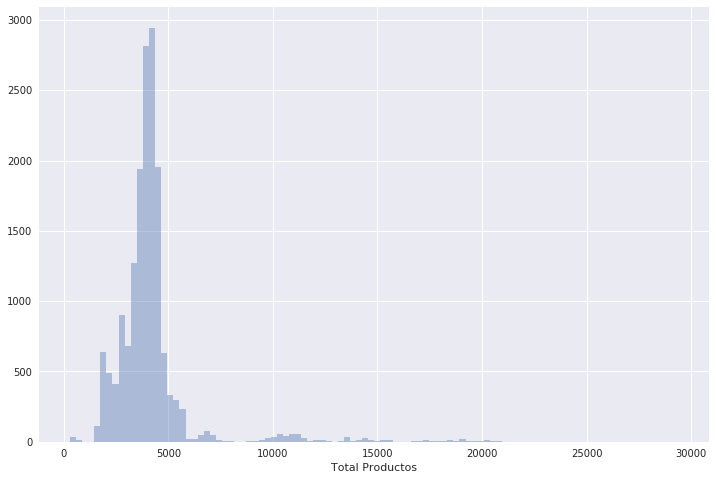

In [150]:
f = plt.figure(figsize=(12,8))
sb.distplot(cot_mod[cot_mod['Total Productos'] > 0]['Total Productos'].dropna(), kde=False, bins=100);

In [151]:
easy_clean('Total Productos')

Nulos 30
Easy Cleaned:  (0, 49)
No nulos 16591


### 1.2.26 Correo Electronico

In [152]:
nulos_n_unicos('Correo Electronico')

Nulos 5
No nulos 16586
Unicos 6081


In [153]:
easy_clean('Correo Electronico')

Nulos 5
Easy Cleaned:  (0, 49)
No nulos 16591


### 1.2.26 Tipo Cliente

In [154]:
nulos_n_unicos('Tipo Cliente')

Nulos 1
No nulos 16590
Unicos 2


In [155]:
print('Nulos', cot_mod[cot_mod['Tipo Cliente'].isnull()].shape)
print('Unicos', cot_mod['Tipo Cliente'].nunique())
# ver_atributo_categorico(cot_mod, 'Total Productos', log=False)

Nulos (1, 49)
Unicos 2


In [156]:
easy_clean('Tipo Cliente')

Nulos 1
Easy Cleaned:  (0, 49)
No nulos 16591


### 1.2.26 Razon Social

In [157]:
nulos_n_unicos('Razon Social')

Nulos 16551
No nulos 40
Unicos 23


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


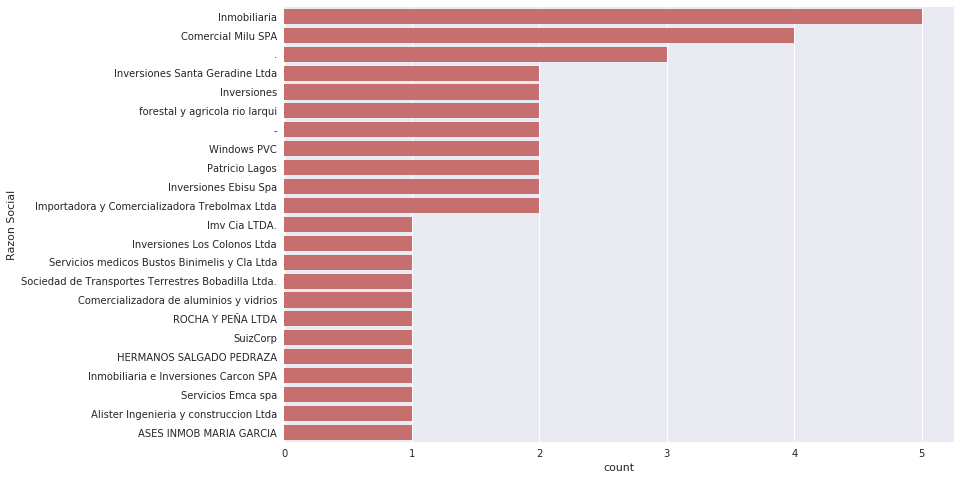

In [158]:
ver_atributo_categorico(cot_mod, 'Razon Social', log=False, limit=True, lim=30)

In [159]:
mask = (cot_mod['Razon Social'].str.len() < 6)
print(cot_mod[mask]['Razon Social'].shape)
print(cot_mod[mask]['Razon Social'].tolist())

(5,)
['-', '-', '.', '.', '.']


In [160]:
easy_clean('Razon Social')

to_replace.extend('-')
pattern_clean('Razon Social')

Nulos 16551
Easy Cleaned:  (0, 49)
No nulos 16591


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


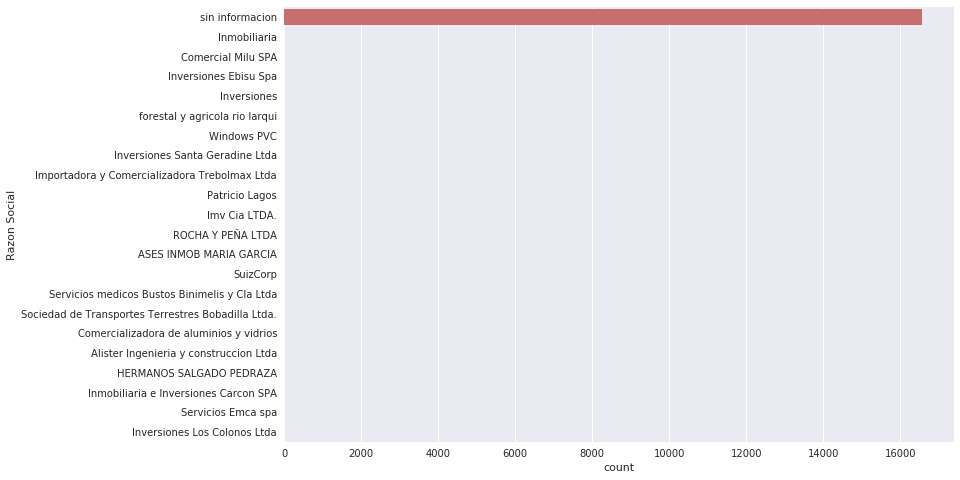

In [161]:
ver_atributo_categorico(cot_mod, 'Razon Social', log=False, limit=True, lim=30)

### 1.2.26 Tipo de Medio

In [162]:
nulos_n_unicos('Tipo de Medio')

Nulos 532
No nulos 16059
Unicos 31


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


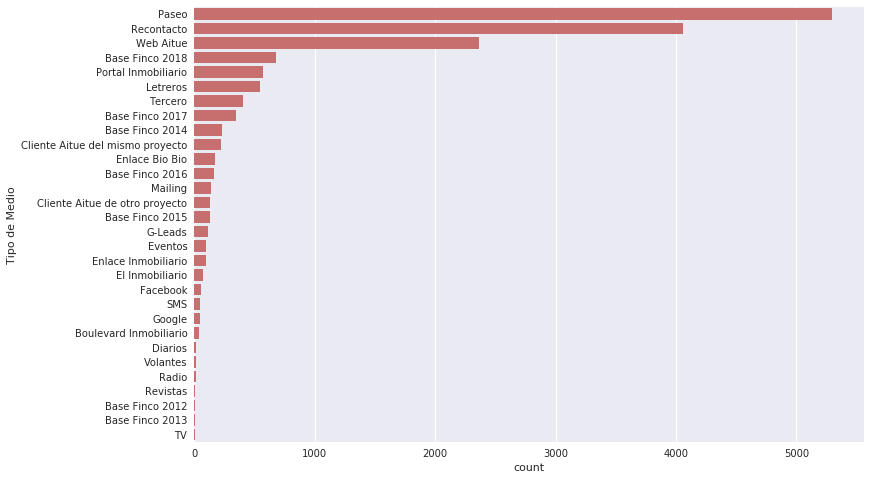

In [163]:
ver_atributo_categorico(cot_mod, 'Tipo de Medio', log=False, limit=True, lim=30)

In [164]:
easy_clean('Tipo de Medio')

Nulos 532
Easy Cleaned:  (0, 49)
No nulos 16591


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


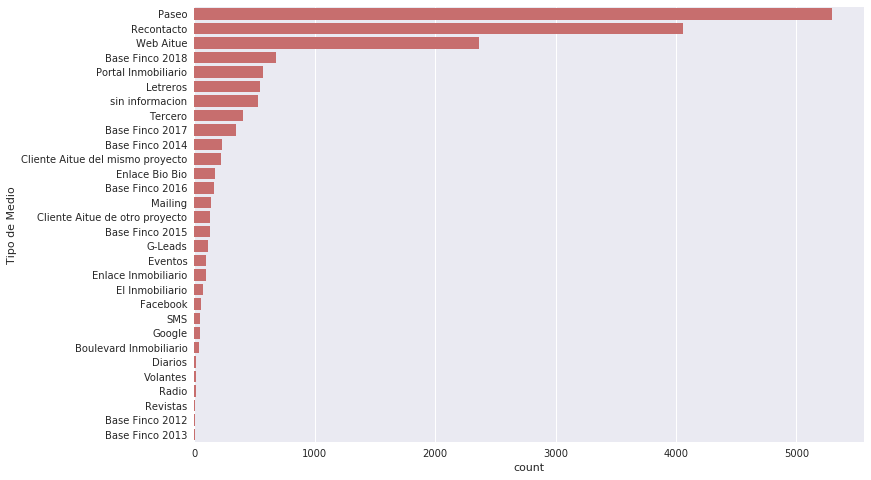

In [165]:
ver_atributo_categorico(cot_mod, 'Tipo de Medio', log=False, limit=True, lim=30)

### 1.2.26 Medio

In [166]:
nulos_n_unicos('Medio')

Nulos 0
No nulos 16591
Unicos 12


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


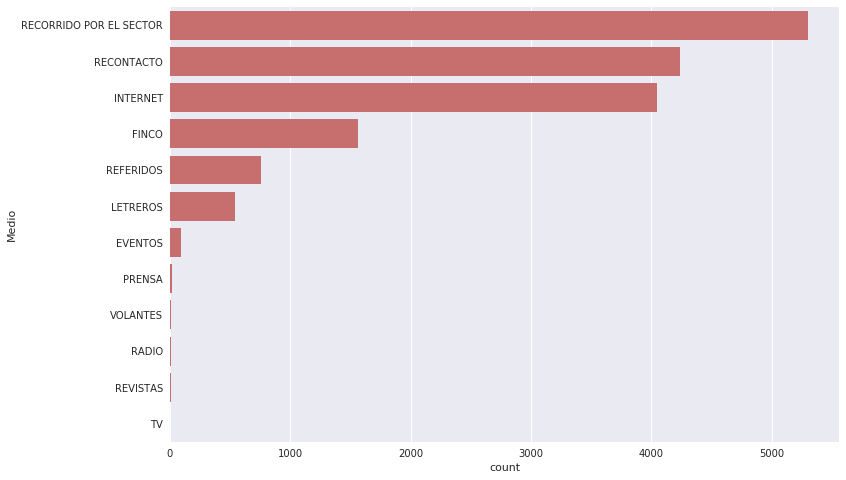

In [167]:
ver_atributo_categorico(cot_mod, 'Medio', log=False, limit=True, lim=30)

# Review Cleaning

In [168]:
cot_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16591 entries, 0 to 16591
Data columns (total 49 columns):
index                  16591 non-null int64
ID                     16591 non-null int64
Fecha Cotizacion       16591 non-null datetime64[ns]
Medio                  16591 non-null object
Tipo de Medio          16591 non-null object
Proyecto               16591 non-null object
Etapa                  16591 non-null object
Productos              16591 non-null object
Presencial             16591 non-null object
Remoto                 16591 non-null object
Jefe Comercial         16591 non-null object
Ejecutivo Comercial    16591 non-null object
Total Productos        16591 non-null object
Descuentos             16591 non-null object
Valor Final Venta      16591 non-null float64
RUT                    16591 non-null object
Nombre                 16591 non-null object
Apellido 1             16591 non-null object
Apellido 2             16591 non-null object
Nombre Completo        16591 

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


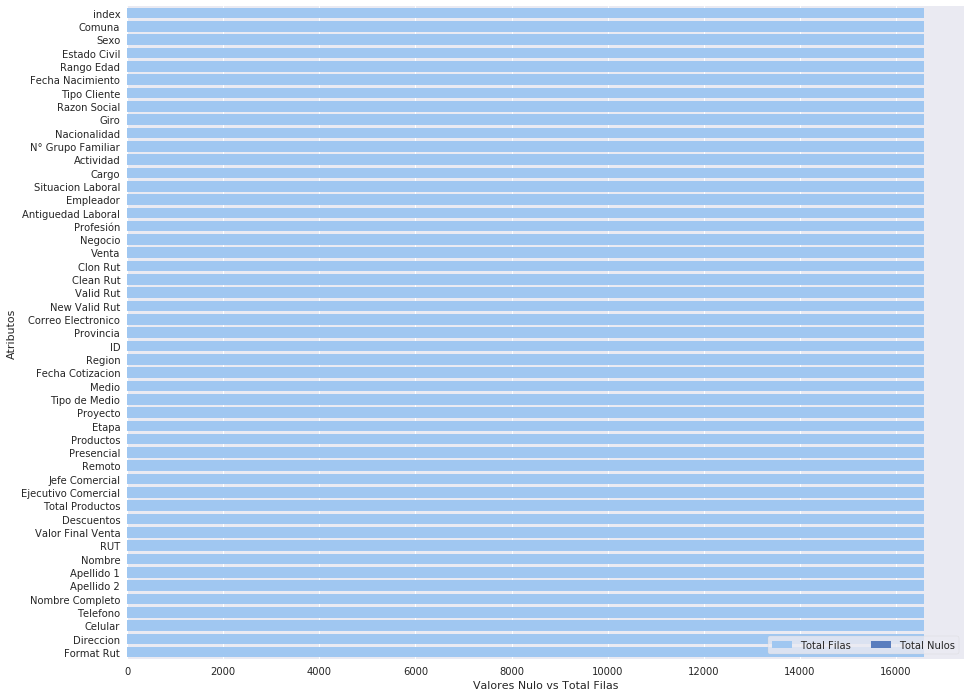

In [169]:
df = cot_mod.copy()
null_columns = df.columns[df.isnull().any()]
nulos = df[null_columns].isnull().sum()

#view all columns with its null count
null_columns = df.columns
null_df =  df.shape[0] - df.count()

null_df = pd.DataFrame({'Total':null_df,'Etiquetas':null_columns})

columnas = null_columns.copy()
filas = [df.shape[0]] * len(null_columns)

totales = pd.DataFrame({'Total':filas,'Etiquetas':columnas})

f, ax = plt.subplots(figsize=(15, 12))

sb.set_color_codes("pastel")
sb.barplot(data=totales.sort_values(by='Total',ascending=False), x='Total', y='Etiquetas',color="b",label="Total Filas")

sb.set_color_codes("muted")
sb.barplot(data=null_df.sort_values(by='Total',ascending=False), x='Total', y='Etiquetas',color="b",label="Total Nulos")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Atributos", xlabel="Valores Nulo vs Total Filas")
# sb.despine(left=True, bottom=True)
f.savefig("..\\results\\cot_all_attributes_clean.png")

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


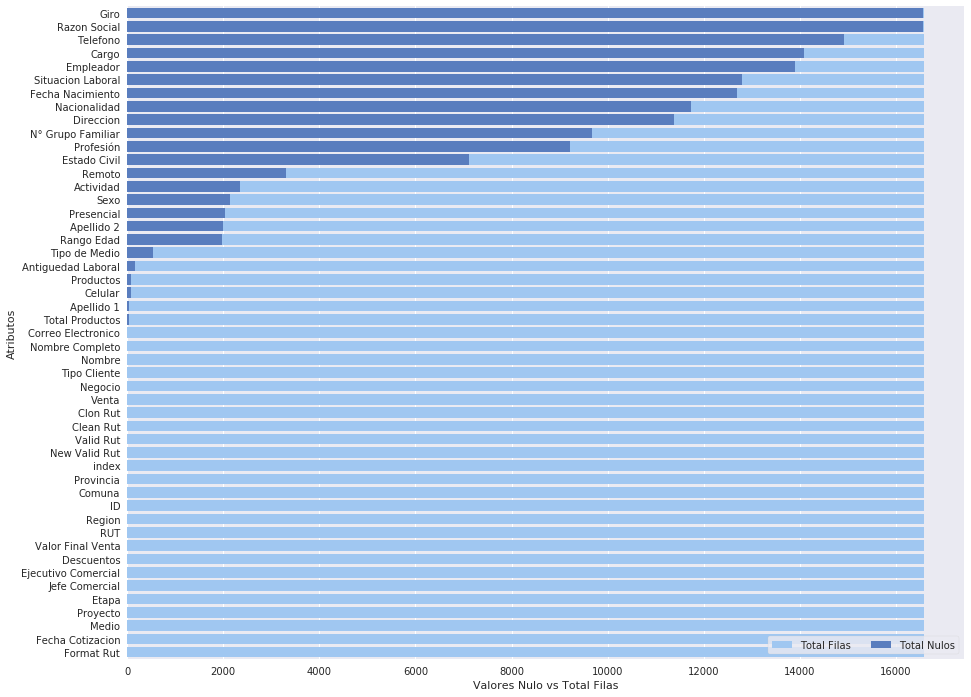

In [170]:
df = cot_mod.copy()
df.replace([REPLACE_WITH], np.nan, inplace=True)
# df.replace(['Sin Información'], np.nan, inplace=True)

null_columns = df.columns[df.isnull().any()]
nulos = df[null_columns].isnull().sum()

#view all columns with its null count
null_columns = df.columns
null_df =  df.shape[0] - df.count()

null_df = pd.DataFrame({'Total':null_df,'Etiquetas':null_columns})

columnas = null_columns.copy()
filas = [df.shape[0]] * len(null_columns)

totales = pd.DataFrame({'Total':filas,'Etiquetas':columnas})

f, ax = plt.subplots(figsize=(15, 12))

sb.set_color_codes("pastel")
sb.barplot(data=totales.sort_values(by='Total',ascending=False), x='Total', y='Etiquetas',color="b",label="Total Filas")

sb.set_color_codes("muted")
sb.barplot(data=null_df.sort_values(by='Total',ascending=False), x='Total', y='Etiquetas',color="b",label="Total Nulos")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Atributos", xlabel="Valores Nulo vs Total Filas")
# sb.despine(left=True, bottom=True)
f.savefig("..\\results\\cot_all_attributes_clean.png")

In [171]:
# cot_mod.replace(['Sin Información'], np.nan, inplace=True)

In [172]:
cot_mod.to_csv("..\\..\\Datos\\working\\cotizaciones_cleaned.csv")
cot_mod.to_excel("..\\..\\Datos\\working\\cotizaciones_cleaned.xlsx")

In [173]:
# De las personas quienes entregaron todos los datos
iterator_all = 0
people_all = []
iterator_any = 0
for group, frame in  df.groupby('Clean Rut'):
    
    cond_all = (
        (~(frame['Cargo'].isnull()).all()) &
        (~(frame['Estado Civil'].isnull()).all()) &
        (~(frame['Situacion Laboral'].isnull()).all()) &
        (~(frame['Rango Edad'].isnull()).all()) &
        (~(frame['Profesión'].isnull()).all()) &
        (~(frame['Actividad'].isnull()).all()) &
        (~(frame['Direccion'].isnull()).all()) &
        (~(frame['N° Grupo Familiar'].isnull()).all()) &
        (~(frame['Actividad'].isnull()).all()) &
        (~(frame['Sexo'].isnull()).all())
    )
    
    if cond_all:
        iterator_all += 1
        people_all.append(group)
    
    cond_any = (
        (~(frame['Cargo'].isnull()).any()) &
        (~(frame['Estado Civil'].isnull()).any()) &
        (~(frame['Situacion Laboral'].isnull()).any()) &
        (~(frame['Rango Edad'].isnull()).any()) &
        (~(frame['Profesión'].isnull()).any()) &
        (~(frame['Actividad'].isnull()).any()) &
        (~(frame['Direccion'].isnull()).any()) &
        (~(frame['N° Grupo Familiar'].isnull()).any()) &
        (~(frame['Actividad'].isnull()).any()) &
        (~(frame['Sexo'].isnull()).any())
    )
    
    if cond_any:
        iterator_any += 1

print(iterator_all, iterator_any)

299 299


In [174]:
tmp = df[df['Format Rut'].isin(people_all)]
tmp

,index,ID,Fecha Cotizacion,Medio,Tipo de Medio,Proyecto,Etapa,Productos,Presencial,Remoto,...,Empleador,Antiguedad Laboral,Profesión,Negocio,Venta,Clon Rut,Clean Rut,Valid Rut,New Valid Rut,Format Rut


In [175]:
tmp = df[df['Format Rut'].isin(people_all)]
print(tmp[tmp.Negocio == True].shape)
print(tmp[tmp.Negocio == False].shape)

(0, 49)
(0, 49)
